In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns

import networkx as nx
import ete3
import dendropy

from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

## 0) Define colors for labels

In [2]:
cmap = {
    #Clades
    'Type A': '#841e5a',
    'Type B': '#f6c19f',
    #Sampling Location
    'Clinical Ab': '#fb9a99',
    'Clinical UK': '#e31a1c',
    'Wastewater Mun. Ab': '#cab2d6',
    'Wastewater Mun. UK': '#6a3d9a',
    'Agricultural Ab': '#b2df8a',
    'Agricultural UK': '#33a02c',
    'Natural Water Ab': '#1f78b4',
    'Wastewater Agr. Ab': '#fdbf6f',
    #Geography
    'United Kingdom': '#9bbdff',
    'Canada/Alberta': '#e36951',
    #Habitat
    'Agricultural': '#33a02c',
    'Wastewater Mun.': '#cab2d6',
    'Clinical': '#e31a1c',
    'Natural Water': '#1f78b4',
    'Wastewater Agr.': '#fdc170',
    #Missing
    np.nan: '#FFFFFF',
}

## Figure 1

In [3]:
df = pd.read_table('genomes_vs_features_longform.csv', sep=',')

In [4]:
type_counts = df[['Feature', 'source', 'Presence']].groupby(['Feature', 'source']).sum()
type_counts.reset_index(inplace=True)
type_counts = type_counts.sort_values(by=['source', 'Presence'], ascending=False)
type_counts.rename({'source': 'Feature Type'}, axis=1, inplace=True)
type_counts.rename({'Presence': 'Count'}, axis=1, inplace=True)

In [5]:
#get the roary gene presence absence table to count genes.
gpa = pd.read_table('gene_presence_absence_roary.csv', sep = ',', low_memory=False)
genomes = gpa.columns[14:] #14th column is start of genomes

#count the number of genes per genome. Absences are NaN
counts = []
for g in genomes:
    absent = gpa[g].isna().sum()
    present = gpa.shape[0] - absent
    counts.append({'Genome ID': g, 'Gene Count': present})
cdf = pd.DataFrame.from_records(counts)
cdf.sort_values(by='Gene Count', inplace=True, ascending=False)

#Get the genome sizes from the QUAST file.
gsizes = pd.read_table('Efaecium_QC_YES_Lists.csv', sep=',')[['Isolate_Pathname','Total length']]
gsizes.sort_values(by='Total length', ascending=False, inplace=True)

In [6]:
#Get the genome sizes from the QUAST file.
gsizes = pd.read_table('Efaecium_QC_YES_Lists.csv', sep=',')[['Isolate_Pathname','Total length']]
gsizes.sort_values(by='Total length', ascending=False, inplace=True)


In [7]:
#First genes, then MGEs.
plot_order = ['AMR',  'Metal', 'VF', 'Plasmid','Genomic Island',  "Phage"]
titles = []
for i, feat in enumerate(plot_order):
    total = type_counts[type_counts['Feature Type'] == feat].shape[0]
    lt5 = type_counts[(type_counts['Count']<5) & (type_counts['Feature Type']==feat)].shape[0]
    gt5 = total - lt5
    titles.append("{0} ({1}/{2})".format(feat, gt5, total))


fig = make_subplots(rows=3, cols=6, 
                    #subplot_titles=['Gene Counts', 'Genome Lengths (nt)'] + plot_order, 
                    subplot_titles = [None, None] + titles,
                    x_title='Feature', 
                    y_title='Feature Count',  
                    vertical_spacing=0.075,
                   specs=[
                       [{'colspan': 3, 'b':0.05}, None, None, {'colspan': 3, 'b':0.05},None, None, ],
                       [{'colspan':2, 't':0.03},None, {'colspan':2,'t':0.03, 'l': 0.03,},None, {'colspan':2,'t':0.03, 'l':0.03}, None],
                       [{'colspan':2, 't':0.03},None, {'colspan':2,'t':0.03, 'l': 0.03},None, {'colspan':2,'t':0.03, 'l': 0.03}, None],
                   ])

#Add the histograms.
fig.add_trace(go.Histogram(x=gsizes['Total length']), row=1, col=1)
fig.add_trace(go.Histogram(x=cdf['Gene Count']), row=1, col=4)

#Add the feature frequency plots.
rows = [2,2,2, 3,3,3]
cols = [1,3,5,1,3,5]
for i, title in enumerate(plot_order):
    row = rows[i]
    col = cols[i]

    data = type_counts[(type_counts['Count']>=5) & (type_counts['Feature Type']==title)]
    x = np.arange(data.shape[0])
    y = data['Count']
    fig.add_trace(go.Bar(x=x, y=y), row=row, col=col)


for i, c in enumerate('ABCDEFGH'):
    label = '({})'.format(c)
    if i == 0:
        xref = "x domain"
        yref = "y domain"
    else:
        xref = "x{} domain".format(i+1)
        yref = "y{} domain".format(i+1)
    fig.add_annotation(xref=xref,
                       yref=yref,
                       x=0.0,
                       y=1.13,
                       text=label,
                       showarrow=False,
                )
        
fig.update_yaxes(title_text='Genome Count', row=1, col=1)
fig.update_layout(height=800, width=1100, showlegend=False)
fig.update_xaxes(title_text='Gene Count', row=1, col=4)
fig.update_xaxes(title_text='Genome Size (nt)', row=1, col=1)

for annot in fig.layout.annotations:
    if annot['text'] in titles:
        annot['y'] = annot['y'] - 0.05
        annot['font'] = {'size': 14}
    if annot['text'] == 'Feature Count':
        annot['y'] = 0.334
fig.update_layout(font={'size':14}, template='plotly_white')
fig.update_yaxes(showgrid=True, gridwidth=1)
#fig.write_image('figures/Figure1__genome_summaries.png', format='png', scale=5)
fig.show()

## Figure 2

In [8]:
sns.set_context('talk')
sns.set_style('white')
sns.set_style('ticks')
hue_order=['Clinical Ab',
           'Clinical UK',
           'Wastewater Mun. Ab', 
           'Wastewater Mun. UK',
           #'Wastewater Agr. UK', doesn't exist
           'Agricultural Ab',
           'Agricultural UK',
           'Natural Water Ab', 
           #'Natural Water UK', doesn't exist
           'Wastewater Agr. Ab', ]
palette=[cmap[h] for h in hue_order]

In [9]:
# df is the feature longform table.
# source_counts will contain feature frequencies per genome.
source_counts = df[['Isolate','Country/Province', 'Habitat', 'source', 'Presence']].groupby(['Isolate', 'Country/Province', 'Habitat', 'source']).sum().reset_index()

In [10]:
#Adds a column to t that contains habitat and country info.
loc_abbr_map = {'United Kingdom': 'UK', 
                'Canada/Alberta': 'Ab'}
source_counts['Sampling Location'] = source_counts.apply(lambda row: ' '.join([row['Habitat'], loc_abbr_map[row['Country/Province']]]), axis=1)

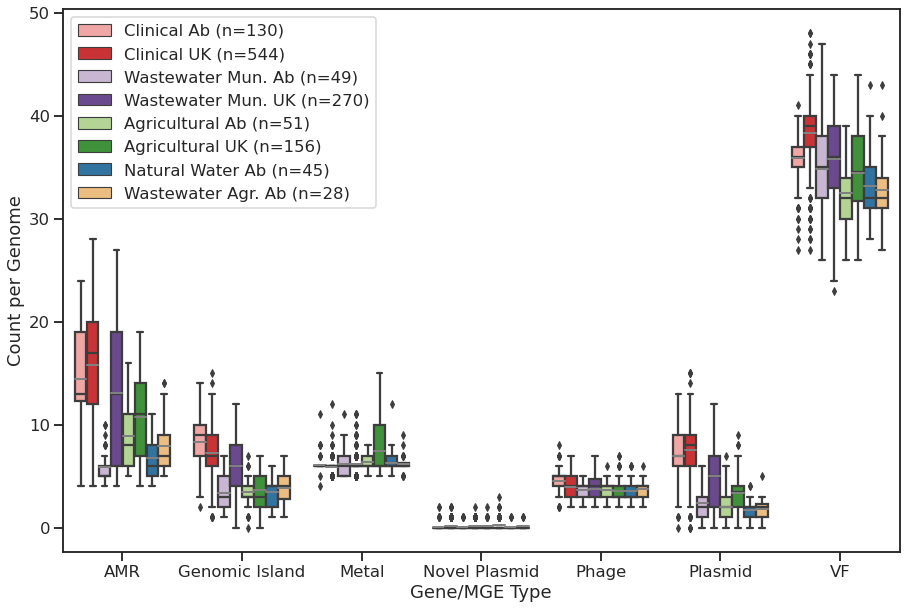

In [11]:
fig, ax = plt.subplots(figsize=(15,10))
ax = sns.boxplot(x='source', hue='Sampling Location', 
                 y='Presence', hue_order=hue_order, palette=palette,
                 data=source_counts,
                 meanline=True,
                 showmeans=True,
                 meanprops = dict(linestyle='solid', linewidth='2', color='grey')
                )

#Add countes
L = plt.legend()
counts = source_counts[['Isolate', 'Sampling Location']].drop_duplicates().groupby(['Sampling Location']).count()
label_list = []
for txt in ax.get_legend_handles_labels():
    label_list.append(txt)

new_list = []
for txt in label_list[1]:
    new_list.append('{0} (n={1})'.format(txt, counts.loc[txt].values[0]))
    
label_list[1] = new_list

ax.legend(handles=label_list[0], labels=label_list[1])
ax.set(xlabel='Gene/MGE Type', ylabel="Count per Genome")
###
plt.savefig('figures/Figure2__feature_boxplots.png', format='png', dpi=300, transparent=False)
plt.show()

# Figure 3

In [12]:
# Metadata file
genome_labels = pd.read_table('genome_labels.csv', sep=',', index_col=0)

In [13]:
genome_labels.head()

Habitat Country/Province    Clade
Isolate                                      
ERR375041  Clinical   United Kingdom  Clade A
ERR374759  Clinical   United Kingdom  Clade A
ERR375156  Clinical   United Kingdom  Clade A
ERR374770  Clinical   United Kingdom  Clade A
ERR375483  Clinical   United Kingdom  Clade A

In [14]:
def swap_label(label):
    if type(label)==str:
        return label.replace('Clade', 'Type')
    return label
genome_labels['Type'] = genome_labels['Clade'].map(swap_label)
genome_labels.head()

Habitat Country/Province    Clade    Type
Isolate                                              
ERR375041  Clinical   United Kingdom  Clade A  Type A
ERR374759  Clinical   United Kingdom  Clade A  Type A
ERR375156  Clinical   United Kingdom  Clade A  Type A
ERR374770  Clinical   United Kingdom  Clade A  Type A
ERR375483  Clinical   United Kingdom  Clade A  Type A

In [15]:
# Get cmaps for each category to make rendering logic simpler
habs = {k:v for k, v in cmap.items() if k in genome_labels['Habitat'].unique()}
geos = {k:v for k, v in cmap.items() if k in genome_labels['Country/Province'].unique()}
clades = {k:v for k, v in cmap.items() if k in genome_labels['Clade'].unique()}
types = {k:v for k, v in cmap.items() if k in genome_labels['Type'].unique()}

In [16]:
types

{'Type A': '#841e5a', 'Type B': '#f6c19f'}

In [17]:
t = ete3.Tree('../phylogram/core_gene_alignment.aln.treefile', format=1)
t.set_outgroup('ehirae')

# Define the annotation process for annotating the tree.
def rects_layout(node):
    if node.name in genome_labels.index:
        node.add_face(ete3.RectFace(height=10, width=40, 
                                    fgcolor=cmap[genome_labels.loc[node.name, 'Habitat']], 
                                    bgcolor=cmap[genome_labels.loc[node.name, 'Habitat']]),
                                    column=0, position='aligned')
        node.add_face(ete3.RectFace(height=10, width=40, 
                            fgcolor=cmap[genome_labels.loc[node.name, 'Country/Province']], 
                            bgcolor=cmap[genome_labels.loc[node.name, 'Country/Province']]),
                            column=1, position='aligned')
        node.add_face(ete3.RectFace(height=10, width=40, 
                            fgcolor=cmap[genome_labels.loc[node.name, 'Type']], 
                            bgcolor=cmap[genome_labels.loc[node.name, 'Type']]),
                            column=2, position='aligned')
 

In [18]:
def rects_layout(node):
    if node.name in genome_labels.index:
        node.add_face(ete3.RectFace(height=10, width=40, 
                                    fgcolor=cmap[genome_labels.loc[node.name, 'Habitat']], 
                                    bgcolor=cmap[genome_labels.loc[node.name, 'Habitat']]),
                                    column=0, position='aligned')
        node.add_face(ete3.RectFace(height=10, width=40, 
                            fgcolor=cmap[genome_labels.loc[node.name, 'Type']], 
                            bgcolor=cmap[genome_labels.loc[node.name, 'Type']]),
                            column=1, position='aligned')

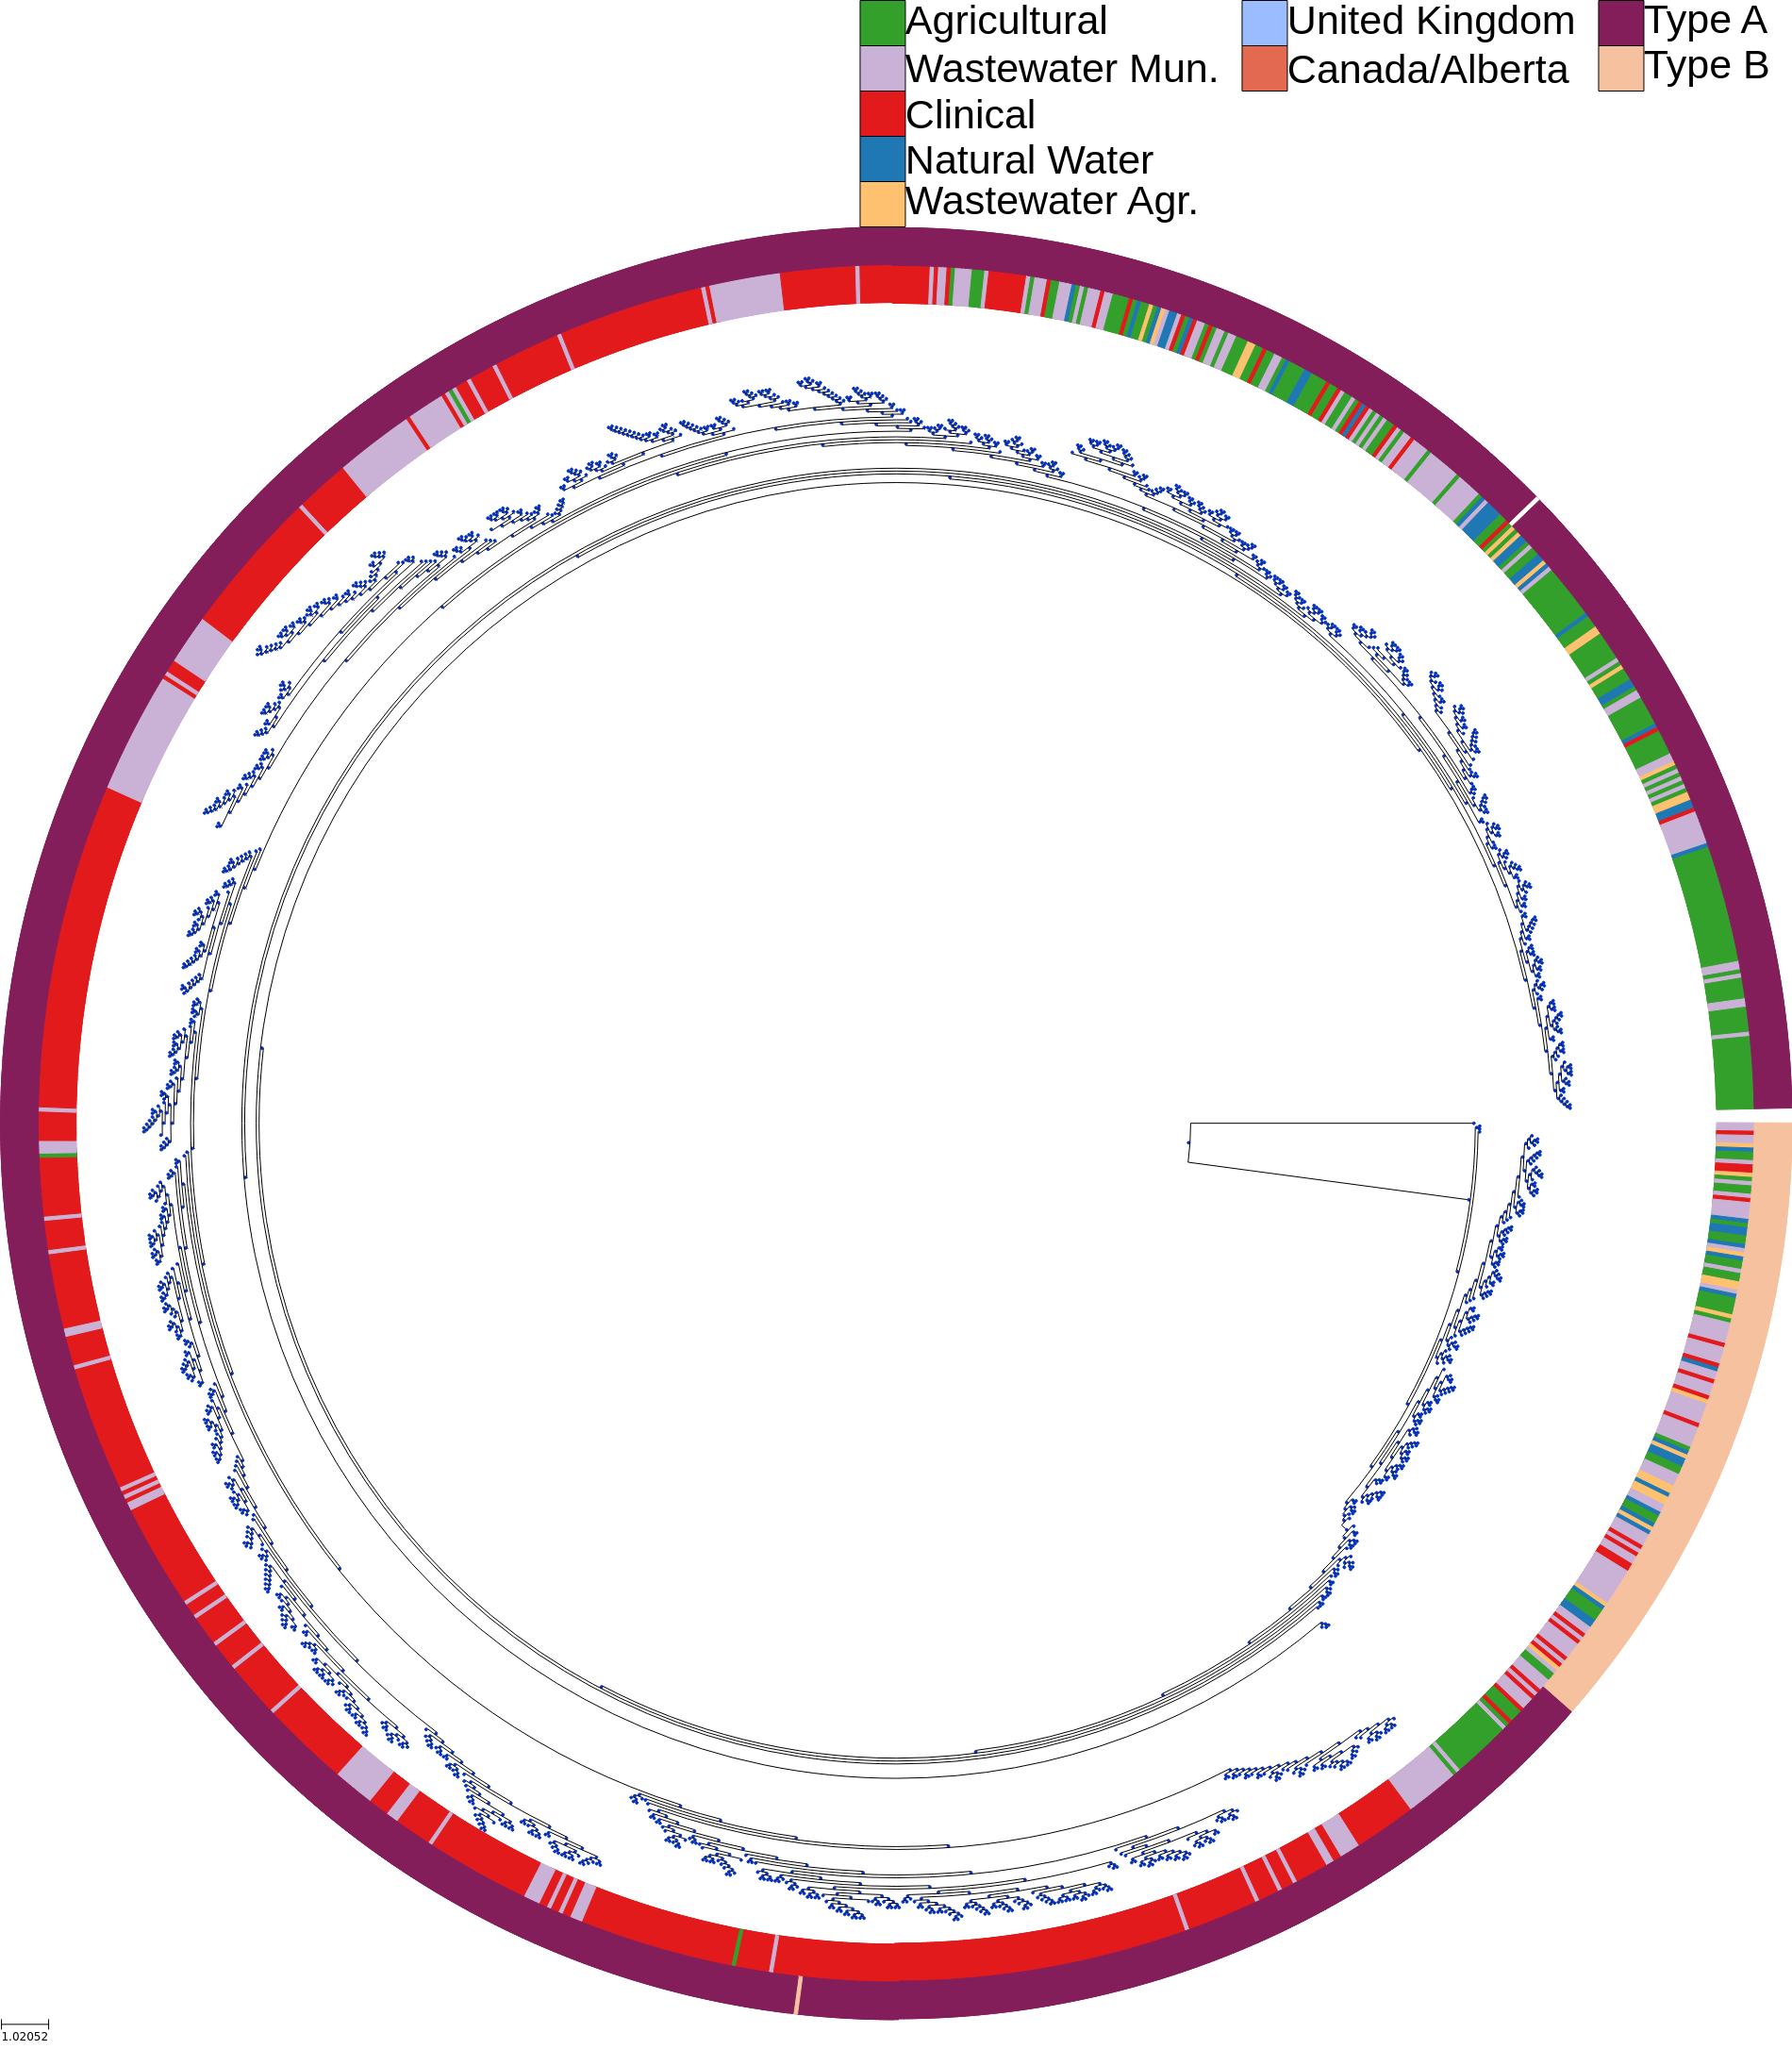

In [19]:
circ_ts1 = ete3.TreeStyle()
circ_ts1.optimal_scale_level="full"
circ_ts1.root_opening_factor=1
circ_ts1.show_leaf_name=False
circ_ts1.mode='c'
circ_ts1.allow_face_overlap = True
circ_ts1.layout_fn = rects_layout

for k, v in habs.items():
    circ_ts1.legend.add_face(ete3.RectFace(48,48, "black", v), column=0)
    circ_ts1.legend.add_face(ete3.TextFace(k + "  ", fsize=32, ftype='Arial', tight_text=True), column=1)
for k, v in geos.items():
    circ_ts1.legend.add_face(ete3.RectFace(48,48, "black", v), column=2)
    circ_ts1.legend.add_face(ete3.TextFace(k+ "  ", fsize=32, ftype='Arial', tight_text=True), column=3)

for k, v in types.items():
    circ_ts1.legend.add_face(ete3.RectFace(48,48, "black", v), column=4)
    circ_ts1.legend.add_face(ete3.TextFace(k+ "  ", fsize=32, ftype='Arial', tight_text=True), column=5)

t.render("%%inline", tree_style=circ_ts1)


In [20]:
circ_ts1 = ete3.TreeStyle()
circ_ts1.optimal_scale_level="full"
circ_ts1.root_opening_factor=1
circ_ts1.show_leaf_name=False
circ_ts1.mode='c'
circ_ts1.allow_face_overlap = True
circ_ts1.layout_fn = rects_layout

for k, v in habs.items():
    circ_ts1.legend.add_face(ete3.RectFace(48,48, "black", v), column=0)
    circ_ts1.legend.add_face(ete3.TextFace(k + "  ", fsize=32, ftype='Arial', tight_text=True), column=1)
for k, v in geos.items():
    circ_ts1.legend.add_face(ete3.RectFace(48,48, "black", v), column=2)
    circ_ts1.legend.add_face(ete3.TextFace(k+ "  ", fsize=32, ftype='Arial', tight_text=True), column=3)

for k, v in types.items():
    circ_ts1.legend.add_face(ete3.RectFace(48,48, "black", v), column=4)
    circ_ts1.legend.add_face(ete3.TextFace(k+ "  ", fsize=32, ftype='Arial', tight_text=True), column=5)
t.render("figures/Figure3__circular_phylogram_raw.png", tree_style=circ_ts1, dpi=300)

{'nodes': [[1257.523722846773,
   968.660946497182,
   1261.7806350273179,
   972.917858677727,
   0,
   None],
  [1560.1511735352317,
   948.1835695439016,
   1564.1511735352317,
   952.1835695439016,
   1,
   None],
  [1554.5012958825293,
   1029.071542732116,
   1558.9963097289353,
   1033.5665565785223,
   2,
   None],
  [1563.1552213878463,
   952.7023039365004,
   1567.1845982424873,
   956.7316807911413,
   3,
   None],
  [1566.3651147110588,
   951.2117671047198,
   1570.3847235298306,
   955.2313759234917,
   4,
   None],
  [1566.2085379602224,
   954.2387168563275,
   1570.2476585230388,
   958.2778374191439,
   5,
   None],
  [1542.2637608985212,
   1104.9878556420767,
   1547.1535928664937,
   1109.877687610049,
   6,
   None],
  [1566.1031339995275,
   957.2653194027125,
   1570.1616687604467,
   961.3238541636318,
   7,
   None],
  [1489.1093342559188,
   1245.0619260866729,
   1494.541182189938,
   1250.4937740206917,
   8,
   None],
  [1524.5582361529923,
   1177.299942

## Figure S1

In [21]:
#df has genomes_vs_features_longform
# Make a geography column for prettier labelling
loc_rename_map = {'United Kingdom': 'UK', 'Canada/Alberta': 'Alberta'}
df['Geography'] = [loc_rename_map[c] for c in df['Country/Province']]

frames = []
for feat in df['source'].unique():
    if feat == 'Novel Plasmid':
        continue
    col = 'Geography'
    data = df[df['source']==feat]
    p = data.groupby(['Geography', 'Feature']).agg({'Presence': 'sum'})
    c = data.groupby([col]).agg({'Isolate': 'nunique'})
    c.rename({'Isolate': 'Presence'}, axis=1, inplace=True)
    perc = p.div(c, level=col).reset_index().pivot(index='Feature', columns=col, values='Presence')
    perc['source'] = feat
    frames.append(perc)
percents = pd.concat(frames)

<Figure size 1440x1440 with 0 Axes>

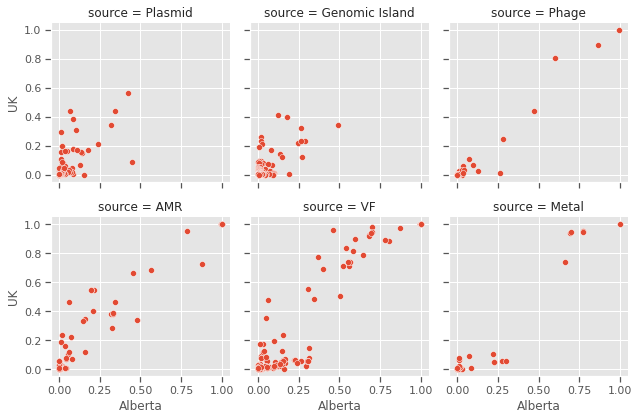

In [22]:
plt.figure(figsize=(20,20))
plt.style.use('ggplot')
sns.set_context('notebook')
g = sns.FacetGrid(percents, col='source', col_wrap=3)
g.map(sns.scatterplot, "Alberta", 'UK')
plt.savefig('figures/FigS1__feature_freq_ab_uk.png', bbox_inches='tight')

## Figure S2

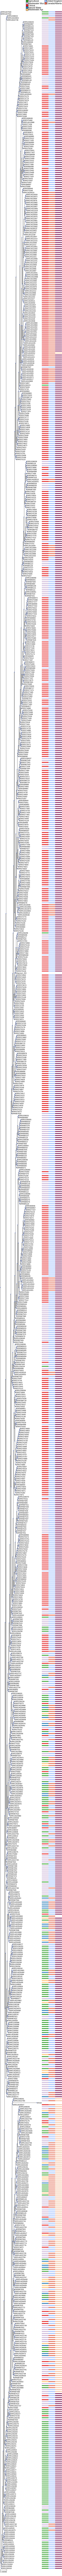

In [38]:
t = ete3.Tree('../phylogram/core_gene_alignment.aln.treefile', format=1)
#t.set_outgroup('ehirae')

rect_ts = ete3.TreeStyle()
def rects_layout(node):
    if node.name in genome_labels.index:
        node.add_face(ete3.RectFace(height=5, width=50, 
                                    fgcolor=cmap[genome_labels.loc[node.name, 'Habitat']], 
                                    bgcolor=cmap[genome_labels.loc[node.name, 'Habitat']]),
                                    column=0, position='aligned')
        node.add_face(ete3.RectFace(height=5, width=50, 
                            fgcolor=cmap[genome_labels.loc[node.name, 'Country/Province']], 
                            bgcolor=cmap[genome_labels.loc[node.name, 'Country/Province']]),
                            column=1, position='aligned')
        node.add_face(ete3.RectFace(height=5, width=50, 
                            fgcolor=cmap[genome_labels.loc[node.name, 'Type']], 
                            bgcolor=cmap[genome_labels.loc[node.name, 'Type']]),
                            column=2, position='aligned')
 

rect_ts.layout_fn = rects_layout

for k, v in habs.items():
    rect_ts.legend.add_face(ete3.RectFace(16,16, "black", v), column=0)
    rect_ts.legend.add_face(ete3.TextFace(k, fsize=12, ftype='Arial', tight_text=True), column=1)
for k, v in geos.items():
    rect_ts.legend.add_face(ete3.RectFace(16,16, "black", v), column=2)
    rect_ts.legend.add_face(ete3.TextFace(k, fsize=12, ftype='Arial', tight_text=True), column=3)
for k, v in clades.items():
    rect_ts.legend.add_face(ete3.RectFace(16,16, "black", v), column=4)
    rect_ts.legend.add_face(ete3.TextFace(k, fsize=12, ftype='Arial', tight_text=True), column=5)



t.render("%%inline", tree_style=rect_ts)

In [31]:
t = ete3.Tree('../phylogram/core_gene_alignment.aln.treefile', format=1)
t.set_outgroup('ehirae')

rect_ts = ete3.TreeStyle()
rect_ts.layout_fn = rects_layout

for k, v in habs.items():
    rect_ts.legend.add_face(ete3.RectFace(16,16, "black", v), column=0)
    rect_ts.legend.add_face(ete3.TextFace(k, fsize=12, ftype='Arial', tight_text=True), column=1)
for k, v in geos.items():
    rect_ts.legend.add_face(ete3.RectFace(16,16, "black", v), column=2)
    rect_ts.legend.add_face(ete3.TextFace(k, fsize=12, ftype='Arial', tight_text=True), column=3)
for k, v in clades.items():
    rect_ts.legend.add_face(ete3.RectFace(16,16, "black", v), column=4)
    rect_ts.legend.add_face(ete3.TextFace(k, fsize=12, ftype='Arial', tight_text=True), column=5)
t.render('figures/FigureS2__phylo_tree_vertical.png', tree_style=rect_ts, dpi=600)

{'nodes': [[0.5, 209.4376444659212, 4.5, 213.4376444659212, 0, None],
  [177.75935337389012, 6.5, 181.75935337389012, 10.5, 1, None],
  [177.75935337389012,
   412.3752889318424,
   181.75935337389012,
   416.3752889318424,
   2,
   None],
  [180.7789548275685, 29.0, 184.7789548275685, 33.0, 3, None],
  [183.89205646271196, 21.5, 187.89205646271196, 25.5, 4, None],
  [183.81949019739295, 36.5, 187.81949019739295, 40.5, 5, None],
  [180.75935591113017,
   795.7505778636848,
   184.75935591113017,
   799.7505778636848,
   6,
   None],
  [183.7854399102612, 51.5, 187.7854399102612, 55.5, 7, None],
  [183.78275306162888,
   1540.0011557273697,
   187.78275306162888,
   1544.0011557273697,
   8,
   None],
  [186.7868181801978,
   1163.0215706825256,
   190.7868181801978,
   1167.0215706825256,
   9,
   None],
  [189.84575809785392,
   1071.2618913650513,
   193.84575809785392,
   1075.2618913650513,
   10,
   None],
  [192.86674807043292,
   989.4612827301025,
   196.86674807043292,
   993.

## Figure S3 a-f

In [23]:
# load tree
#t = ete3.Tree('../phylogram/core_gene_alignment.aln.treefile', format=1)
t = ete3.Tree('core_gene_tree_um.nwk', format=1)
# root tree
t.set_outgroup('ehirae')
# Convert to ultrametric for plotting
#t.convert_to_ultrametric()
# Use dendropy to extract the distance matrix from the tree
tree = dendropy.Tree.get(data=t.write(), schema='newick')
dm = pd.DataFrame.from_records(tree.phylogenetic_distance_matrix().as_data_table()._data)
# compressed distance matrix from the ultrametric tree
um = squareform(dm[dm.index])
# compute linkage for clustering 
ultrameric_link = linkage(um)

In [24]:
# get colors for the genomes into a dataframe
genome_colors = genome_labels.copy()
genome_colors.drop('Clade', axis=1, inplace=True)
for col in genome_colors.columns:
    genome_colors[col] = [cmap[c] for c in genome_colors[col]]

# format a legend key for plotting
legend_keys = []
for i, col in enumerate(genome_labels.columns):
    legend_keys += sorted(list(genome_labels[col].dropna().unique()))
legend_cmap = {k:v for k, v in cmap.items() if k in legend_keys}        

# color map for presence/absence
pa_cmap = sns.color_palette(['#f5f5f5', '#021657'])

In [25]:
legend_cmap

{'Type A': '#841e5a',
 'Type B': '#f6c19f',
 'United Kingdom': '#9bbdff',
 'Canada/Alberta': '#e36951',
 'Agricultural': '#33a02c',
 'Wastewater Mun.': '#cab2d6',
 'Clinical': '#e31a1c',
 'Natural Water': '#1f78b4',
 'Wastewater Agr.': '#fdc170'}

In [26]:
#load presence absence data
pa = pd.read_table('presence_absence_all_relabelled.tsv', index_col=0)
# add reference and outgroup genome to PA for plotting. 
for genome in set(dm.index) - set(pa.index):
    pa.loc[genome] = 0
# load featute label data
features = pd.read_table('feature_sources.tsv')



In [27]:
#AMR feature names are sooo long that they ruin the figure sometimes. I'm going to remap them here.
feature = 'AMR'

sel = type_counts[(type_counts['Feature Type']==feature) & (type_counts['Count'] >=5)]
long_names = []
for f in sel['Feature'].drop_duplicates():
    if len(f) > 6:
        long_names.append(f)
long_names

['Trimethoprim.resistant.dihydrofolate.reductase.DfrA42',
 'AAC.6...Ii',
 'APH.3...IIIa',
 'AAC.6...Ie.APH.2....Ia',
 'tet.45.',
 'tet.W.N.W.',
 'ANT.6..Ia',
 'Enterococcus.faecium.liaS.mutant.conferring.daptomycin.resistance',
 'Enterococcus.faecium.liaR.mutant.conferring.daptomycin.resistance',
 'ANT.9..Ia',
 'OXA.129',
 'Enterococcus.faecium.chloramphenicol.acetyltransferase',
 'Lactobacillus.reuteri.cat.TC',
 'Enterococcus.faecalis.chloramphenicol.acetyltransferase']

In [84]:
name_map = {'Trimethoprim.resistant.dihydrofolate.reductase.DfrA42': 'dfrA42',
 'AAC.6...Ii': "aac(6')-Ii", 
 'APH.3...IIIa': "aph(3')-IIIa",
 'AAC.6...Ie.APH.2....Ia': "aac(6′)-Ie-aph(2′′)-Ia",
 'tet.45.': "tet(45)",
 'tet.W.N.W.': "tet(W/N/W)",
 'tet.L.': 'tetL',
 'SAT.4' : 'sat4', 
 'liaR': 'liaR*',
 'liaS': 'liaS*',
 'eatAv': 'eatAv*',
 'ANT.6..Ia' : "ant(6)-Ia",
 'Enterococcus.faecium.liaS.mutant.conferring.daptomycin.resistance': 'liaS',
 'Enterococcus.faecium.liaR.mutant.conferring.daptomycin.resistance': 'liaR',
 'ANT.9..Ia': "ant(9)-Ia",
 'OXA.129': "blaOXA-129",
 'Enterococcus.faecium.chloramphenicol.acetyltransferase': "e.faecium CAT",
 'Lactobacillus.reuteri.cat.TC': "cat-TC", 
 'Enterococcus.faecalis.chloramphenicol.acetyltransferase': "e. faecalis CAT",
 'ErmA': 'ermA',
 'ErmB': 'ermB',
 'ErmT': 'ermT'
           }

/home/alex/anaconda3/envs/biopython/lib/python3.9/site-packages/pandas/core/frame.py:5039: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/alex/anaconda3/envs/biopython/lib/python3.9/site-packages/seaborn/matrix.py:654: UserWarning:

Clustering large matrix with scipy. Installing `fastcluster` may give better performance.



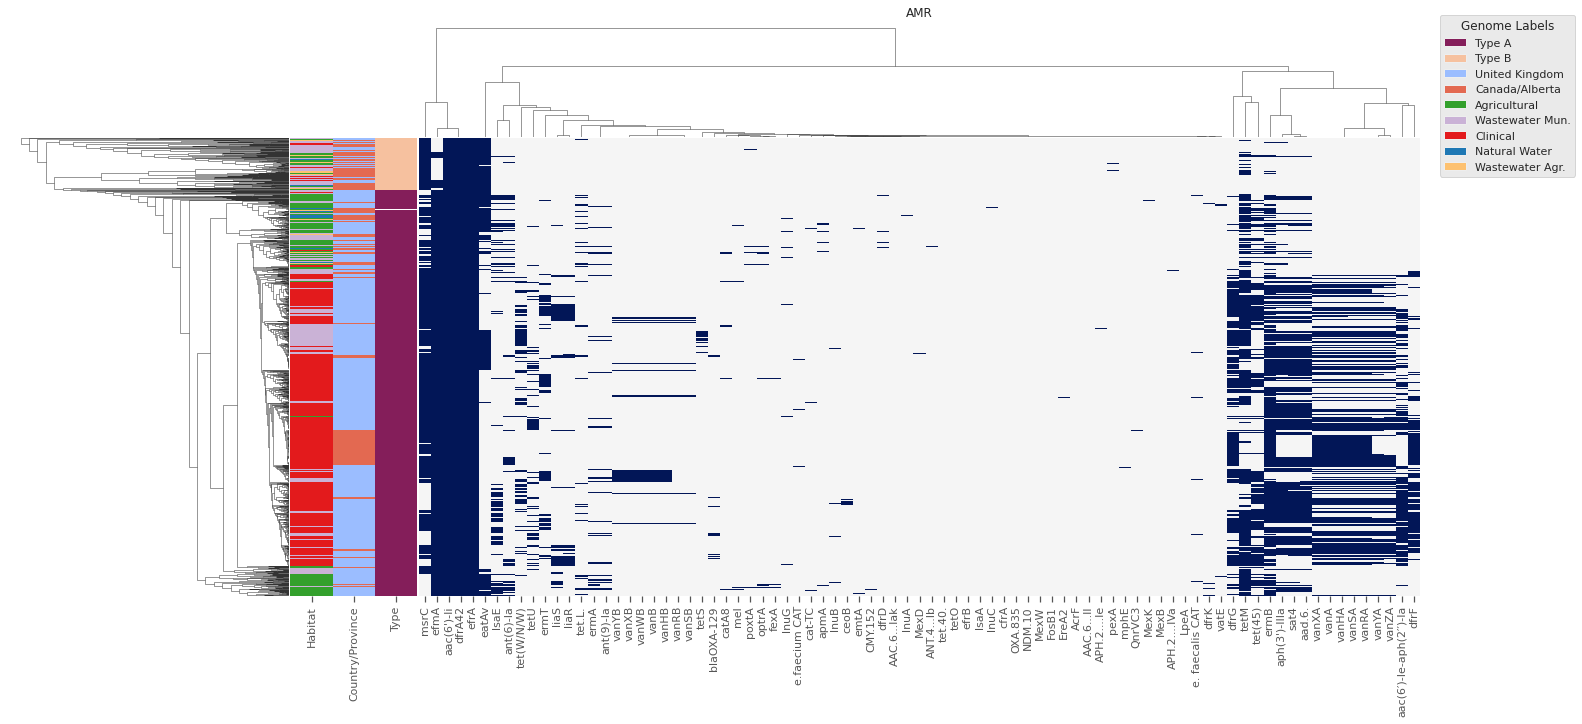

In [40]:
########## Select the feature ##############
feature = 'AMR'
panel = 'a'
#sel = type_counts[(type_counts['Feature Type']==feature) & (type_counts['Count'] >=5)]
sel = type_counts[(type_counts['Feature Type']==feature)]
sel_pa = pa[sel['Feature']]
sel_pa.rename(name_map, axis=1, inplace=True)

#total = type_counts[type_counts['Feature Type'] == feature].shape[0]
#lt5 = type_counts[(type_counts['Count']<5) & (type_counts['Feature Type']==feature)].shape[0]
#gt5 = total - lt5
#title = "{0} ({1}/{2})".format(feature, gt5, total)
title = feature
###########################################
#plot
handles = [Patch(facecolor=legend_cmap[name]) for name in legend_cmap]
g = sns.clustermap(data=sel_pa.loc[dm.index], 
                   row_linkage=ultrameric_link, 
                   method='complete', metric='cityblock',
                   cbar_pos=None, row_colors=genome_colors,
                   cmap=pa_cmap, 
                   xticklabels=1, yticklabels=False,
                   figsize=(20,10))
g.ax_col_dendrogram.set_title(title)
plt.legend(handles, legend_cmap, title='Genome Labels',
           bbox_to_anchor=(1, 1), bbox_transform=plt.gcf().transFigure, loc='upper left')
plt.savefig('figures/FigureS3{0}__{1}_clustergram.png'.format(panel, feature), bbox_inches='tight', dpi=300)

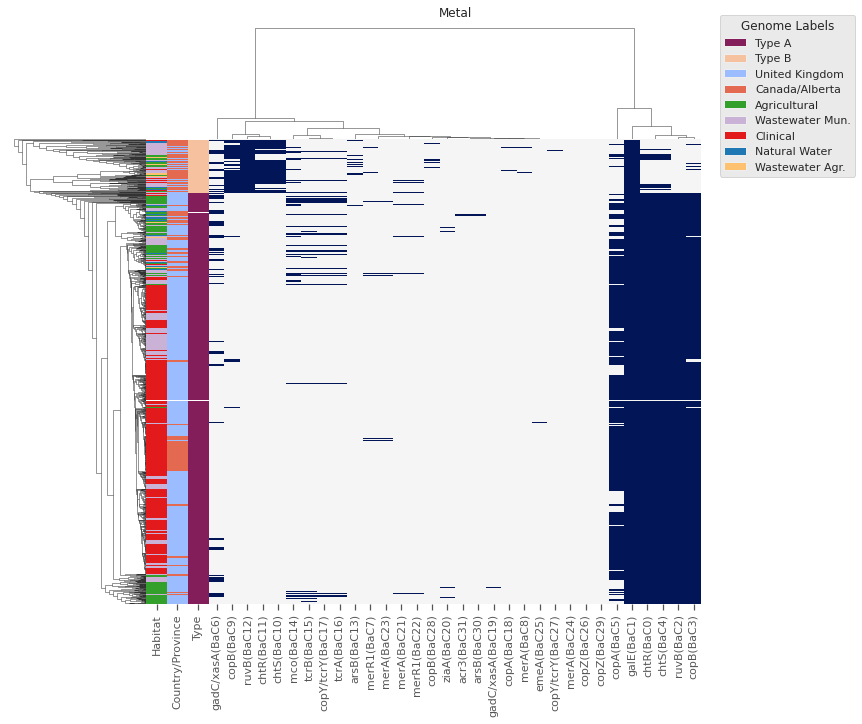

In [41]:
########## Select the feature ##############
feature = 'Metal'
panel = 'b'
sel = type_counts[(type_counts['Feature Type']==feature)]
sel_pa = pa[sel['Feature']]

title = feature
###########################################
#plot
#plot
handles = [Patch(facecolor=legend_cmap[name]) for name in legend_cmap]
g = sns.clustermap(data=sel_pa.loc[dm.index], 
                   row_linkage=ultrameric_link, 
                   method='complete', metric='cityblock',
                   cbar_pos=None, row_colors=genome_colors,
                   cmap=pa_cmap, 
                   xticklabels=1, yticklabels=False,
                   )
g.ax_col_dendrogram.set_title(title)
plt.legend(handles, legend_cmap, title='Genome Labels',
           bbox_to_anchor=(1, 1), bbox_transform=plt.gcf().transFigure, loc='upper left')
plt.savefig('figures/FigureS3{0}__{1}_clustergram.png'.format(panel, feature), bbox_inches='tight', dpi=300)

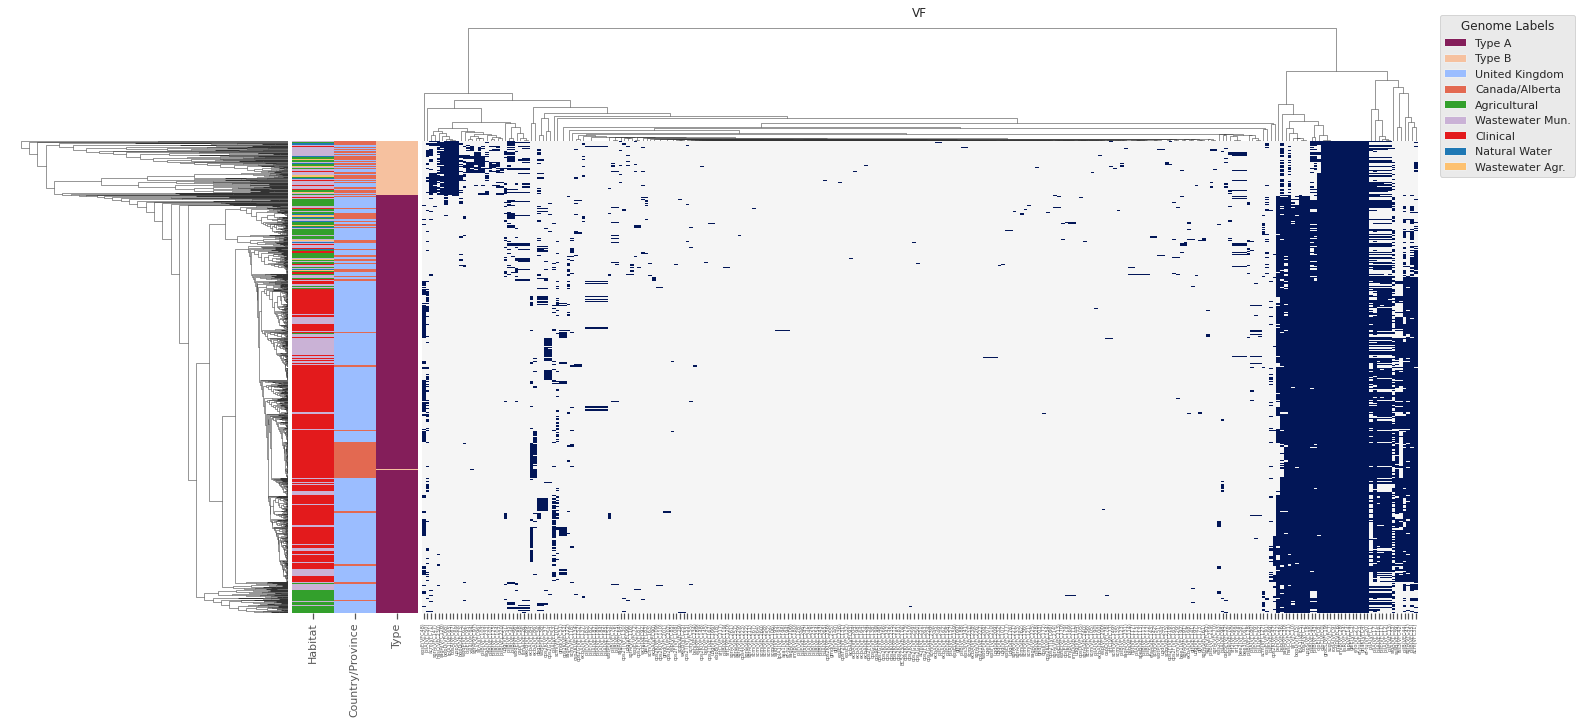

In [42]:
########## Select the feature ##############
feature = 'VF'
panel = 'c'
#sel = type_counts[(type_counts['Feature Type']==feature) & (type_counts['Count'] >=5)]
sel = type_counts[(type_counts['Feature Type']==feature)]
sel_pa = pa[sel['Feature']]

#total = type_counts[type_counts['Feature Type'] == feature].shape[0]
#lt5 = type_counts[(type_counts['Count']<5) & (type_counts['Feature Type']==feature)].shape[0]
#gt5 = total - lt5
#title = "{0} ({1}/{2})".format(feature, gt5, total)
title=feature
###########################################
#plot
handles = [Patch(facecolor=legend_cmap[name]) for name in legend_cmap]
g = sns.clustermap(data=sel_pa.loc[dm.index], 
                   row_linkage=ultrameric_link, 
                   cbar_pos=None, row_colors=genome_colors,
                   cmap=pa_cmap,
                   method='complete', metric='cityblock',
                   xticklabels=1, yticklabels=False, figsize=(20,10))
g.ax_col_dendrogram.set_title(title)
plt.legend(handles, legend_cmap, title='Genome Labels',
           bbox_to_anchor=(1, 1), bbox_transform=plt.gcf().transFigure, loc='upper left')
plt.xticks(fontsize=5)
plt.savefig('figures/FigureS3{0}__{1}_clustergram.png'.format(panel, feature), bbox_inches='tight', dpi=300)

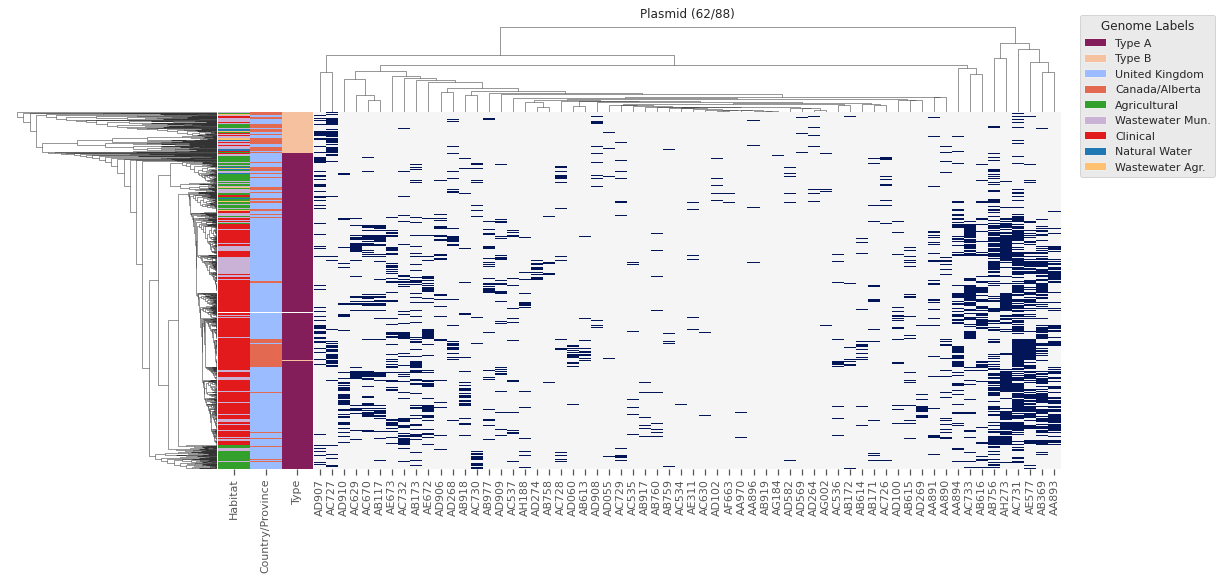

In [43]:
########## Select the feature ##############
feature = 'Plasmid'
panel = 'd'
sel = type_counts[(type_counts['Feature Type']==feature) & (type_counts['Count'] >=5)]
sel_pa = pa[sel['Feature']]

total = type_counts[type_counts['Feature Type'] == feature].shape[0]
lt5 = type_counts[(type_counts['Count']<5) & (type_counts['Feature Type']==feature)].shape[0]
gt5 = total - lt5
title = "{0} ({1}/{2})".format(feature, gt5, total)
###########################################

#plot
handles = [Patch(facecolor=legend_cmap[name]) for name in legend_cmap]
g = sns.clustermap(data=sel_pa.loc[dm.index], 
                   row_linkage=ultrameric_link, 
                   cbar_pos=None, row_colors=genome_colors,
                   cmap=pa_cmap,
                   method='complete', metric='cityblock',
                   xticklabels=1, yticklabels=False, figsize=(15,8))
g.ax_col_dendrogram.set_title(title)
plt.legend(handles, legend_cmap, title='Genome Labels',
           bbox_to_anchor=(1, 1), bbox_transform=plt.gcf().transFigure, loc='upper left')
#plt.xticks(fontsize=6)
plt.savefig('figures/FigureS3{0}__{1}_clustergram.png'.format(panel, feature), bbox_inches='tight', dpi=300)

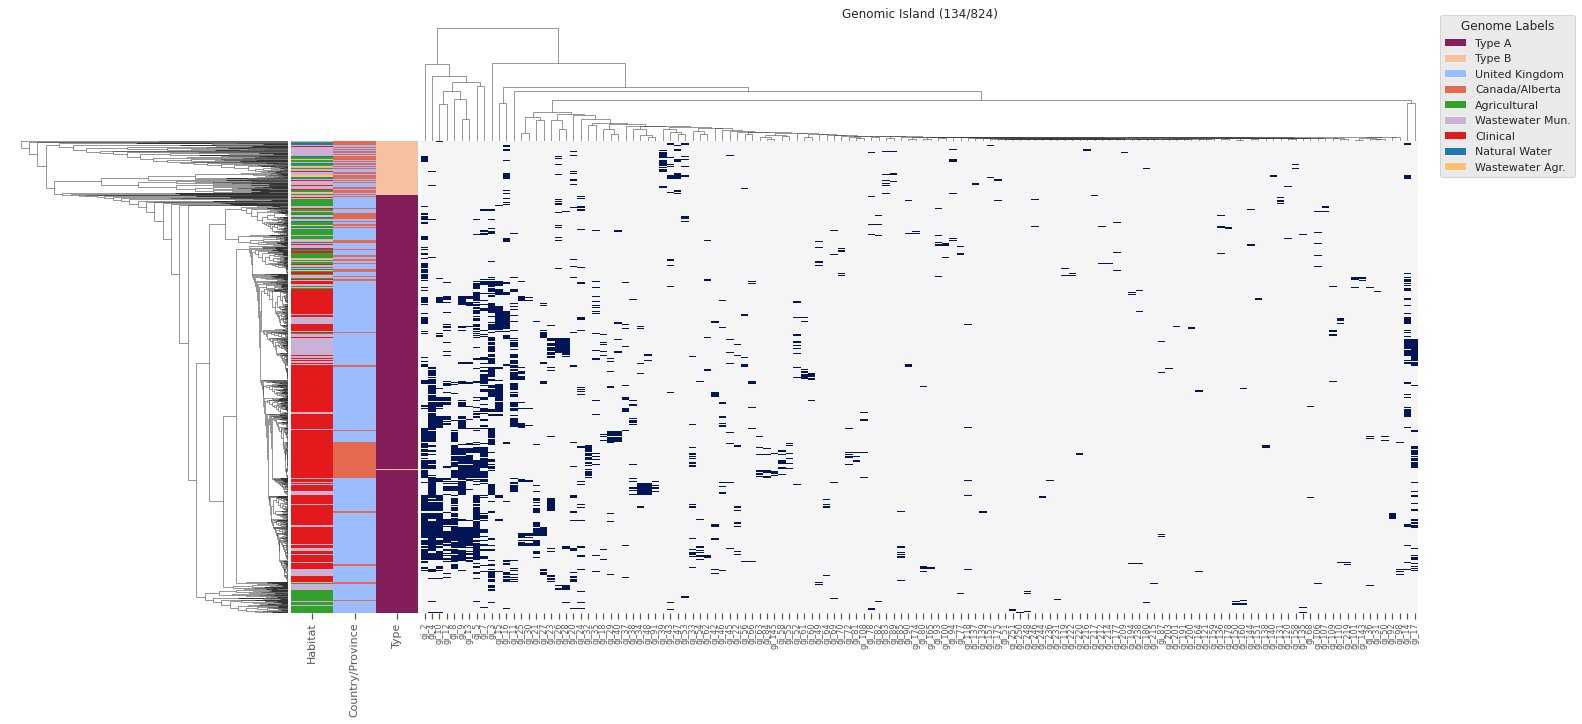

In [44]:
########## Select the feature ##############
feature = 'Genomic Island'
panel = 'e'

sel = type_counts[(type_counts['Feature Type']==feature) & (type_counts['Count'] >=5)]
sel_pa = pa[sel['Feature']]

total = type_counts[type_counts['Feature Type'] == feature].shape[0]
lt5 = type_counts[(type_counts['Count']<5) & (type_counts['Feature Type']==feature)].shape[0]
gt5 = total - lt5
title = "{0} ({1}/{2})".format(feature, gt5, total)
###########################################

#plot
handles = [Patch(facecolor=legend_cmap[name]) for name in legend_cmap]
g = sns.clustermap(data=sel_pa.loc[dm.index], 
                   row_linkage=ultrameric_link, 
                   cbar_pos=None, row_colors=genome_colors,
                   cmap=pa_cmap,
                   method='complete', metric='cityblock',
                   xticklabels=1, yticklabels=False, figsize=(20,10))
g.ax_col_dendrogram.set_title(title)
plt.legend(handles, legend_cmap, title='Genome Labels',
           bbox_to_anchor=(1, 1), bbox_transform=plt.gcf().transFigure, loc='upper left')
plt.xticks(fontsize=8)
plt.savefig('figures/FigureS3{0}__{1}_clustergram.png'.format(panel, feature), bbox_inches='tight', dpi=300)

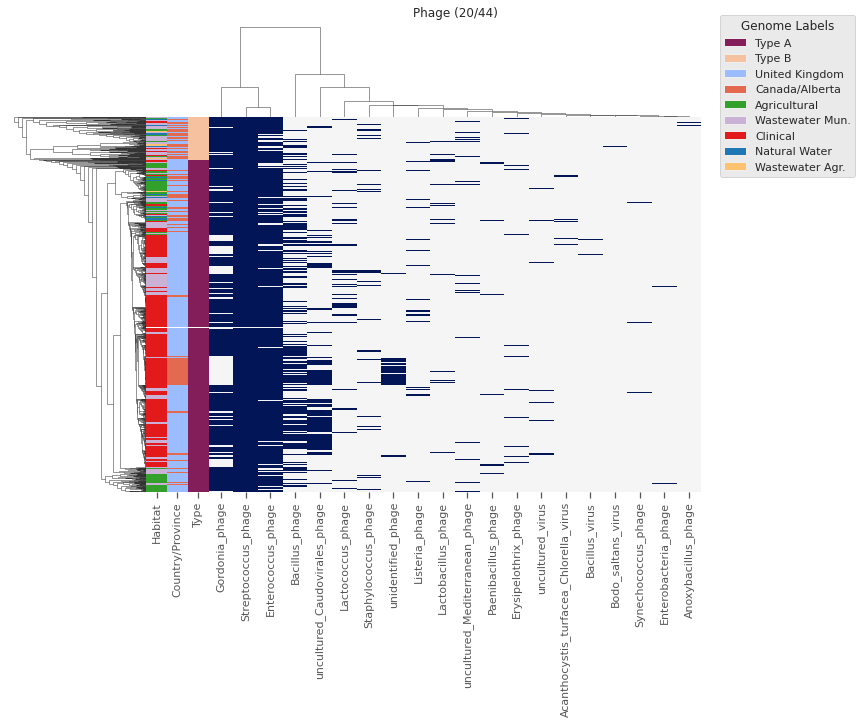

In [45]:
########## Select the feature ##############
feature = 'Phage'
panel = 'f'
sel = type_counts[(type_counts['Feature Type']==feature) & (type_counts['Count'] >=5)]
sel_pa = pa[sel['Feature']]

total = type_counts[type_counts['Feature Type'] == feature].shape[0]
lt5 = type_counts[(type_counts['Count']<5) & (type_counts['Feature Type']==feature)].shape[0]
gt5 = total - lt5
title = "{0} ({1}/{2})".format(feature, gt5, total)
###########################################
#plot
handles = [Patch(facecolor=legend_cmap[name]) for name in legend_cmap]
g = sns.clustermap(data=sel_pa.loc[dm.index], 
                   row_linkage=ultrameric_link, 
                   cbar_pos=None, row_colors=genome_colors,
                   cmap=pa_cmap,
                   method='complete', metric='cityblock',
                   xticklabels=1, yticklabels=False)
g.ax_col_dendrogram.set_title(title)
plt.legend(handles, legend_cmap, title='Genome Labels',
           bbox_to_anchor=(1, 1), bbox_transform=plt.gcf().transFigure, loc='upper left')
#plt.xticks(fontsize=6)
plt.savefig('figures/FigureS3{0}__{1}_clustergram.png'.format(panel, feature), bbox_inches='tight', dpi=300)

## Figure X (Position unassigned)

In [46]:
# Load drug class data and tweak the labels.
drug_class = pd.read_table('../AMR_Drug_Classes_Curated.tsv')
drug_class['Drug Class'] = [c.lower() for c in drug_class['Drug Class']]
len(drug_class['Drug Class'].unique())

rename = []
for f in drug_class['Feature']:
    if f in name_map.keys():
        rename.append(name_map[f])
    else:
        rename.append(f)
drug_class['Feature'] = rename

In [47]:
# Custom Functions to Sort Genes
def sort_gene_names_by_terminal(gene_names):
    terminals = set( [gene[-1] for gene in gene_names] )
    sets = {k: [] for k in terminals}
    for gene in gene_names:
        sets[gene[-1]].append(gene)

    sorted_genes = []
    for key in sorted(sets.keys(), key=str.casefold):
        for gene in sorted(sets[key]):
            sorted_genes.append(gene)
    return sorted_genes

def sort_gene_names_by_prefix(gene_names):
    prefixes = set(gene[:3] for gene in gene_names)
    sets = {k: [] for k in prefixes}
    for gene in gene_names:
        sets[gene[:3]].append(gene)
    sorted_genes = []
    for key in sorted(sets.keys(), key=str.casefold):
        for gene in sort_gene_names_by_terminal(sets[key]):
            sorted_genes.append(gene)
    return sorted_genes

In [71]:
#if you want to sort by habitat
gl_alt = genome_colors.sort_values(by=['Habitat', 'Country/Province',  'Type'])

In [82]:
sel_pa.columns

Index(['aac(6′)-Ie-aph(2′′)-Ia', 'aac(6')-Ii', 'aad.6.', 'ant(6)-Ia',
       'ant(9)-Ia', 'aph(3')-IIIa', 'blaOXA-129', 'liaR*', 'liaS*', 'vanA',
       'vanHA', 'vanRA', 'vanSA', 'vanXA', 'vanYA', 'vanZA', 'vanB', 'vanHB',
       'vanRB', 'vanSB', 'vanWB', 'vanXB', 'vanYB', 'lnuG', 'lsaE', 'ermA',
       'ermB', 'ermT', 'mel', 'msrC', 'eatAv', 'efmA', 'efrA', 'poxtA',
       'optrA', 'catA8', 'cat-TC', 'e.faecium CAT', 'sat4', 'tet(45)',
       'tet(W/N/W)', 'tetM', 'tetS', 'tetU', 'dfrF', 'dfrG'],
      dtype='object')

In [94]:
def rename_amr(g):
    if g in name_map.keys():
        return name_map[g]
    return g

/tmp/ipykernel_96189/212990887.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_96189/212990887.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



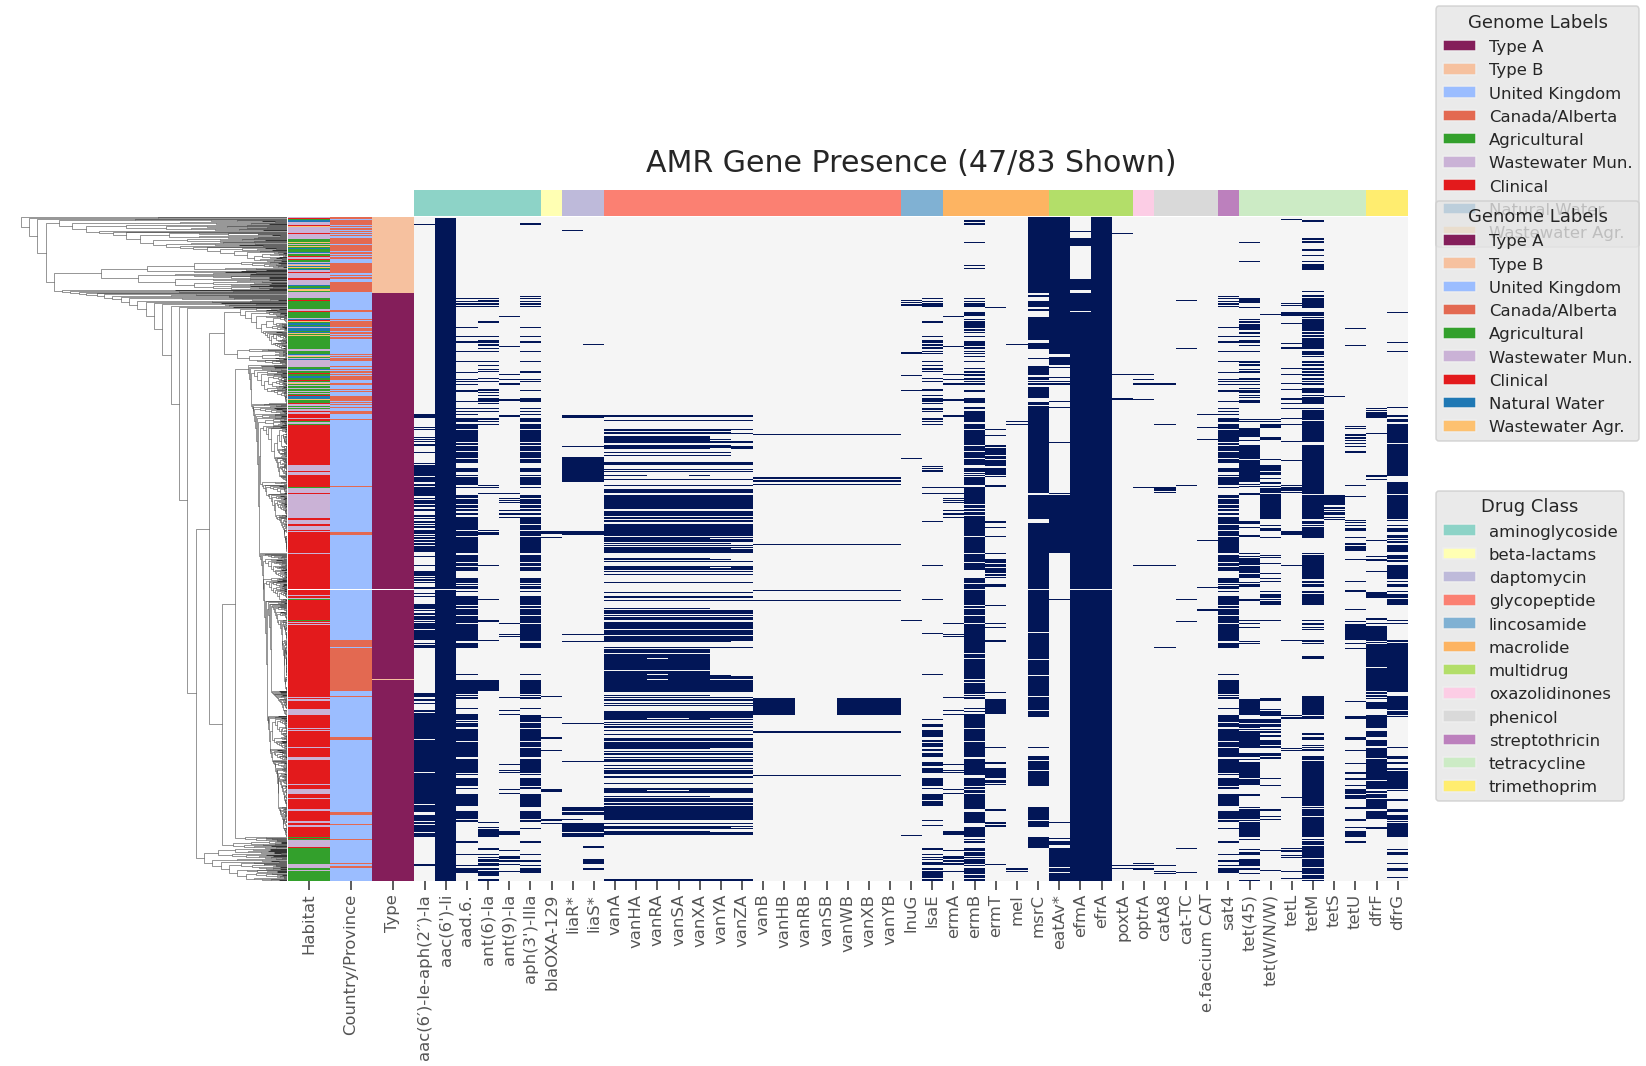

In [159]:
feature = "AMR"

sel = type_counts[(type_counts['Feature Type']==feature) & (type_counts['Count']>=12)]
sel_pa = pa[sel['Feature']]

sel['Feature'] = sel['Feature'].map(rename_amr)
drug_class['Feature'] = drug_class['Feature'].map(rename_amr)

sel['Feature'] = sel['Feature'].map(rename_amr)

joined = sel.set_index('Feature').join(drug_class.set_index('Feature')).reset_index().dropna()
gene_sort = sort_gene_names_by_prefix(joined['Feature'].unique())
gene_map = {gene: i for i, gene in enumerate(gene_sort)}
joined['gene_sort'] = joined['Feature'].map(gene_map)
joined.sort_values(by=['Drug Class', 'gene_sort'], inplace=True)
joined.drop('gene_sort', axis=1, inplace=True)


# Colors for amr 
drug_cmap ={k:v for k, v in  zip(joined['Drug Class'].unique(), sns.color_palette('Set3', 12).as_hex())}
col_colors = [drug_cmap[d] for d in joined['Drug Class']]

#sel_pa = pa.rename(name_map, axis=1)[joined['Feature']]
sel_pa = sel_pa.rename(name_map, axis=1)
sel_pa = sel_pa.rename(name_map, axis=1)
sel_pa = sel_pa[joined['Feature']]
total = type_counts[type_counts['Feature Type'] == feature].shape[0]
#lt5 = type_counts[(type_counts['Count']<12) & (type_counts['Feature Type']==feature)].shape[0]
#gt5 = total - lt5
gt5 = sel_pa.columns.shape[0]
title = "{0} Gene Presence ({1}/{2} Shown)".format(feature, gt5, total)

###########################################
#plot


sns.set_context('talk')
handles = [Patch(facecolor=legend_cmap[name]) for name in legend_cmap]
handles2 = [Patch(facecolor=drug_cmap[name]) for name in drug_cmap]
g = sns.clustermap(data=sel_pa.loc[dm.index],
                   row_linkage=ultrameric_link,
                   cbar_pos=None, row_colors=genome_colors,
                   col_colors=col_colors,
                   cmap=pa_cmap, col_cluster=False,
                   xticklabels=1, yticklabels=False,
                   figsize=(20,15))
g.ax_heatmap.set_title(title, fontdict={'fontsize': 30},y=1, pad=45)
g.ax_col_colors.legend(handles, legend_cmap, title='Genome Labels',
           bbox_to_anchor=(1, 1), bbox_transform=plt.gcf().transFigure, loc='upper left')
l1 = plt.legend(handles, legend_cmap, title='Genome Labels',
           bbox_to_anchor=(1, 0.82), bbox_transform=plt.gcf().transFigure, loc='upper left')
plt.gca().add_artist(l1)
plt.legend(handles2, drug_cmap, title='Drug Class',
           bbox_to_anchor=(1, 0.4), bbox_transform=plt.gcf().transFigure, loc='center left')


plt.savefig('figures/FigureX__amr_clustermap_with_drug_classes.png', bbox_inches="tight", dpi=300)

In [110]:
type_counts[(type_counts['Feature Type']=='AMR') & (type_counts['Count']>=12)]

Feature Feature Type   Count
160   Trimethoprim.resistant.dihydrofolate.reductase...          AMR  1273.0
275                                                efrA          AMR  1273.0
12                                           AAC.6...Ii          AMR  1271.0
274                                                efmA          AMR  1163.0
1159                                               msrC          AMR   968.0
121                                                ErmB          AMR   835.0
1466                                               tetM          AMR   783.0
97                                         APH.3...IIIa          AMR   595.0
154                                               SAT.4          AMR   591.0
162                                              aad.6.          AMR   589.0
251                                                dfrG          AMR   553.0
1487                                               vanA          AMR   474.0
1489                                              vanHA          AMR   474.0
1496                                              vanXA          AMR   474.0
254                                               eatAv          AMR   472.0
1493                                              vanSA          AMR   470.0
11                               AAC.6...Ie.APH.2....Ia          AMR   468.0
1491                                              vanRA          AMR   467.0
1463                                            tet.45.          AMR   455.0
1498                                              vanYA          AMR   386.0
250                                                dfrF          AMR   370.0
1500                                              vanZA          AMR   369.0
1149                                               lsaE          AMR   237.0
1465                                         tet.W.N.W.          AMR   236.0
122                                                ErmT          AMR   187.0
1469                                               tetU          AMR   168.0
93                                            ANT.6..Ia          AMR   166.0
117   Enterococcus.faecium.liaS.mutant.conferring.da...          AMR   133.0
116   Enterococcus.faecium.liaR.mutant.conferring.da...          AMR   116.0
1464                                             tet.L.          AMR    90.0
120                                                ErmA          AMR    85.0
94                                            ANT.9..Ia          AMR    82.0
1488                                               vanB          AMR    57.0
1490                                              vanHB          AMR    57.0
1495                                              vanWB          AMR    57.0
1497                                              vanXB          AMR    57.0
1499                                              vanYB          AMR    57.0
1468                                               tetS          AMR    37.0
144                                             OXA.129          AMR    24.0
1492                                              vanRB          AMR    24.0
1494                                              vanSB          AMR    24.0
186                                               catA8          AMR    23.0
1144                                               lnuG          AMR    21.0
1335                                              optrA          AMR    20.0
1390                                              poxtA          AMR    16.0
115   Enterococcus.faecium.chloramphenicol.acetyltra...          AMR    14.0
129                        Lactobacillus.reuteri.cat.TC          AMR    13.0
1151                                                mel          AMR    13.0

## Figure S4

In [51]:
rgi = pd.read_table('rgi_all.csv', sep=',')


In [52]:
for hit in rgi['Best_Hit_ARO'].unique():
    if len(hit) > 7:
        print(hit)

AAC(6')-Ii
Trimethoprim-resistant dihydrofolate reductase DfrA42
Enterococcus faecalis chloramphenicol acetyltransferase
APH(3')-IIIa
ANT(9)-Ia
AAC(6')-Ie-APH(2'')-Ia
Enterococcus faecium liaR mutant conferring daptomycin resistance
Enterococcus faecium liaS mutant conferring daptomycin resistance
tet(W/N/W)
AAC(6')-Iak
ANT(6)-Ia
Lactobacillus reuteri cat-TC
AAC(6')-Il
Enterococcus faecium chloramphenicol acetyltransferase
ANT(4')-Ib
APH(2'')-IVa
APH(2'')-Ie


In [53]:
rgi['AMR Gene Family'].unique()

array(['tetracycline-resistant ribosomal protection protein',
       'major facilitator superfamily (MFS) antibiotic efflux pump',
       "AAC(6')", 'trimethoprim resistant dihydrofolate reductase dfr',
       'ATP-binding cassette (ABC) antibiotic efflux pump',
       'ABC-F ATP-binding cassette ribosomal protection protein',
       'Erm 23S ribosomal RNA methyltransferase',
       'chloramphenicol acetyltransferase (CAT)',
       'vanZ; glycopeptide resistance gene cluster',
       'vanY; glycopeptide resistance gene cluster',
       'vanX; glycopeptide resistance gene cluster',
       'glycopeptide resistance gene cluster; van ligase',
       'vanH; glycopeptide resistance gene cluster',
       'vanS; glycopeptide resistance gene cluster',
       'glycopeptide resistance gene cluster; vanR', 'macrolide esterase',
       "APH(3')", 'streptothricin acetyltransferase (SAT)', 'ANT(6)',
       'ANT(9)', "APH(2''); AAC(6')",
       'vanW; glycopeptide resistance gene cluster',
       'dap

In [54]:
rgi.columns

Index(['ORF_ID', 'Contig', 'Start', 'Stop', 'Orientation', 'Cut_Off',
       'Pass_Bitscore', 'Best_Hit_Bitscore', 'Best_Hit_ARO', 'Best_Identities',
       'ARO', 'Model_type', 'SNPs_in_Best_Hit_ARO', 'Other_SNPs', 'Drug Class',
       'Resistance Mechanism', 'AMR Gene Family', 'Predicted_DNA',
       'Predicted_Protein', 'CARD_Protein_Sequence',
       'Percentage Length of Reference Sequence', 'ID', 'Model_ID', 'Nudged',
       'Note', 'Genome_ID'],
      dtype='object')

## Fig S5

In [55]:
pagel = pd.read_table('pagel_vs_metadata_pvalue.csv', sep=',', index_col=0)
pagel

AA890         AA891         AA893         AA894  \
Agriculture           0.002139  1.086360e-04  1.372498e-15  2.976511e-07   
Alberta               0.557007  5.521770e-02  1.125662e-05  8.904274e-05   
Clade A               0.297285  3.516790e-02  1.013106e-05  4.026031e-06   
CladeB                0.241281  4.926673e-02  9.040668e-06  3.617921e-06   
Clinical              0.171333  1.628313e-12  1.021019e-36  3.601249e-23   
Natural Water         0.210947  1.238611e-01  4.867080e-04  1.301992e-02   
UK                    0.557007  5.521770e-02  1.125662e-05  8.904274e-05   
Wastewater Agr.       0.564387  4.533088e-01  3.480736e-02  8.078008e-01   
Wastewater Municipal  0.257360  8.576873e-04  2.918764e-07  3.034008e-06   

                         AA896     AA970  AAC.6...Iak  AAC.6...Ie.APH.2....Ia  \
Agriculture           0.972512  0.436169     0.714798            9.739575e-23   
Alberta               0.497409  0.477735     0.776490            1.865200e-13   
Clade A               0.593783  0.740293     0.990346            5.409110e-13   
CladeB                0.863871  0.827054     1.000000            6.385952e-14   
Clinical              0.218900  0.796405     0.912018            1.060252e-44   
Natural Water         0.964996  0.953183     0.988853            3.095094e-06   
UK                    0.497409  0.477735     0.776490            1.865200e-13   
Wastewater Agr.       0.990224  0.986489     0.996997            3.142847e-03   
Wastewater Municipal  0.334845  0.957698     0.986107            1.572799e-02   

                      AAC.6...Ii     AB020  ...     vanSB         vanWB  \
Agriculture             0.758254  0.895684  ...  0.042626  1.219728e-02   
Alberta                 0.126673  0.236792  ...  0.057802  1.813054e-02   
Clade A                 0.845238  1.000000  ...  0.392573  2.440739e-01   
CladeB                  0.872706  1.000000  ...  0.293633  1.537514e-01   
Clinical                0.126070  0.323848  ...  0.000029  5.015827e-09   
Natural Water           0.995937  0.994361  ...  0.737141  5.010193e-01   
UK                      0.126673  0.236792  ...  0.057802  1.813054e-02   
Wastewater Agr.         0.998943  0.998413  ...  0.905466  7.763652e-01   
Wastewater Municipal    0.818758  0.595967  ...  0.103059  2.523630e-03   

                             vanXA         vanXB         vanYA         vanYB  \
Agriculture           5.449657e-28  1.219728e-02  1.094250e-22  1.219728e-02   
Alberta               1.315836e-13  1.813054e-02  1.461191e-11  1.813054e-02   
Clade A               4.091088e-18  2.440739e-01  1.174990e-13  2.440739e-01   
CladeB                2.342789e-16  1.537514e-01  3.808037e-14  1.537514e-01   
Clinical              2.217012e-40  5.015827e-09  5.278848e-28  5.015827e-09   
Natural Water         1.189716e-06  5.010193e-01  2.240549e-05  5.010193e-01   
UK                    1.315836e-13  1.813054e-02  1.461191e-11  1.813054e-02   
Wastewater Agr.       2.117349e-03  7.763652e-01  8.656584e-03  7.763652e-01   
Wastewater Municipal  2.483681e-03  2.523630e-03  4.640913e-02  2.523630e-03   

                             vanZA      vatE       Alberta            UK  
Agriculture           1.259412e-21  0.046446  7.212286e-28  7.212286e-28  
Alberta               4.163505e-13  0.755366           NaN           NaN  
Clade A               2.576938e-13  0.996566  3.283617e-15  3.295628e-15  
CladeB                1.809073e-13  0.922906  3.285107e-15  3.283466e-15  
Clinical              2.636652e-25  0.503080  5.466408e-11  5.466408e-11  
Natural Water         3.998410e-05  0.982650  2.676465e-25  2.676465e-25  
UK                    4.163505e-13  0.755366           NaN           NaN  
Wastewater Agr.       1.141378e-02  0.995071  4.491862e-13  4.491862e-13  
Wastewater Municipal  6.312958e-02  0.652164  3.549840e-06  3.549840e-06  

[9 rows x 589 columns]

In [56]:
pagel = pagel[[col for col in pagel.columns if col not in pagel.index]]


In [57]:
test = pagel.T.reset_index()
test.rename({'index': 'Feature'}, axis=1, inplace=True)
test

Feature   Agriculture       Alberta       Clade A        CladeB  \
0     AA890  2.138574e-03  5.570071e-01  2.972854e-01  2.412812e-01   
1     AA891  1.086360e-04  5.521770e-02  3.516790e-02  4.926673e-02   
2     AA893  1.372498e-15  1.125662e-05  1.013106e-05  9.040668e-06   
3     AA894  2.976511e-07  8.904274e-05  4.026031e-06  3.617921e-06   
4     AA896  9.725121e-01  4.974094e-01  5.937828e-01  8.638714e-01   
..      ...           ...           ...           ...           ...   
575   vanXB  1.219728e-02  1.813054e-02  2.440739e-01  1.537514e-01   
576   vanYA  1.094250e-22  1.461191e-11  1.174990e-13  3.808037e-14   
577   vanYB  1.219728e-02  1.813054e-02  2.440739e-01  1.537514e-01   
578   vanZA  1.259412e-21  4.163505e-13  2.576938e-13  1.809073e-13   
579    vatE  4.644622e-02  7.553658e-01  9.965664e-01  9.229058e-01   

         Clinical  Natural Water            UK  Wastewater Agr.  \
0    1.713334e-01       0.210947  5.570071e-01         0.564387   
1    1.628313e-12       0.123861  5.521770e-02         0.453309   
2    1.021019e-36       0.000487  1.125662e-05         0.034807   
3    3.601249e-23       0.013020  8.904274e-05         0.807801   
4    2.189001e-01       0.964996  4.974094e-01         0.990224   
..            ...            ...           ...              ...   
575  5.015827e-09       0.501019  1.813054e-02         0.776365   
576  5.278848e-28       0.000022  1.461191e-11         0.008657   
577  5.015827e-09       0.501019  1.813054e-02         0.776365   
578  2.636652e-25       0.000040  4.163505e-13         0.011414   
579  5.030800e-01       0.982650  7.553658e-01         0.995071   

     Wastewater Municipal  
0            2.573595e-01  
1            8.576873e-04  
2            2.918764e-07  
3            3.034008e-06  
4            3.348451e-01  
..                    ...  
575          2.523630e-03  
576          4.640913e-02  
577          2.523630e-03  
578          6.312958e-02  
579          6.521641e-01  

[580 rows x 10 columns]

In [58]:
pagel_long = test.melt(id_vars=['Feature'], 
           value_vars=[col for col in test.columns if col != 'Feature'],
           var_name='Metadata', value_name='p_val' 
           )

In [59]:
pagel_long

Feature              Metadata         p_val
0      AA890           Agriculture  2.138574e-03
1      AA891           Agriculture  1.086360e-04
2      AA893           Agriculture  1.372498e-15
3      AA894           Agriculture  2.976511e-07
4      AA896           Agriculture  9.725121e-01
...      ...                   ...           ...
5215   vanXB  Wastewater Municipal  2.523630e-03
5216   vanYA  Wastewater Municipal  4.640913e-02
5217   vanYB  Wastewater Municipal  2.523630e-03
5218   vanZA  Wastewater Municipal  6.312958e-02
5219    vatE  Wastewater Municipal  6.521641e-01

[5220 rows x 3 columns]

In [60]:
catmap = {'Agriculture': "Habitat",
          'Alberta':'Geography',
          'Clade A': "Type",
          'CladeB': "Type",
          'Clinical': "Habitat",
       'Natural Water': "Habitat",
          'UK':"Geography",
          'Wastewater Agr.': "Habitat",
          'Wastewater Municipal': "Habitat"}

In [61]:
pagel_long['Metadata'] = [catmap[c] for c in pagel_long['Metadata']]
pagel_long

Feature Metadata         p_val
0      AA890  Habitat  2.138574e-03
1      AA891  Habitat  1.086360e-04
2      AA893  Habitat  1.372498e-15
3      AA894  Habitat  2.976511e-07
4      AA896  Habitat  9.725121e-01
...      ...      ...           ...
5215   vanXB  Habitat  2.523630e-03
5216   vanYA  Habitat  4.640913e-02
5217   vanYB  Habitat  2.523630e-03
5218   vanZA  Habitat  6.312958e-02
5219    vatE  Habitat  6.521641e-01

[5220 rows x 3 columns]

In [62]:
pagel_long = pagel_long.set_index('Feature').join(type_counts[['Feature', 'Feature Type']].set_index('Feature')).reset_index()
pagel_long

Feature   Metadata     p_val Feature Type
0           AA890    Habitat  0.002139      Plasmid
1           AA890  Geography  0.557007      Plasmid
2           AA890       Type  0.297285      Plasmid
3           AA890       Type  0.241281      Plasmid
4           AA890    Habitat  0.171333      Plasmid
...           ...        ...       ...          ...
5215  ziaA(BaC20)    Habitat  0.173859        Metal
5216  ziaA(BaC20)    Habitat  0.803141        Metal
5217  ziaA(BaC20)  Geography  0.135707        Metal
5218  ziaA(BaC20)    Habitat  0.872620        Metal
5219  ziaA(BaC20)    Habitat  0.639299        Metal

[5220 rows x 4 columns]

In [63]:
pagel_long['Feature Type'].unique()

array(['Plasmid', 'AMR', 'Phage', 'VF', 'Metal', 'Genomic Island',
       'Novel Plasmid'], dtype=object)

In [64]:
pagel_long["log(p)"] = np.log10(pagel_long['p_val'])

In [65]:
pagel_long['-log(p)'] = [-n for n in pagel_long['log(p)']]
pagel_long.head()

Feature   Metadata     p_val Feature Type    log(p)   -log(p)
0   AA890    Habitat  0.002139      Plasmid -2.669876  2.669876
1   AA890  Geography  0.557007      Plasmid -0.254139  0.254139
2   AA890       Type  0.297285      Plasmid -0.526826  0.526826
3   AA890       Type  0.241281      Plasmid -0.617476  0.617476
4   AA890    Habitat  0.171333      Plasmid -0.766158  0.766158

In [66]:
counts

Isolate
Sampling Location          
Agricultural Ab          51
Agricultural UK         156
Clinical Ab             130
Clinical UK             544
Natural Water Ab         45
Wastewater Agr. Ab       28
Wastewater Mun. Ab       49
Wastewater Mun. UK      270

ValueError: Could not interpret input 'Sampling Location'

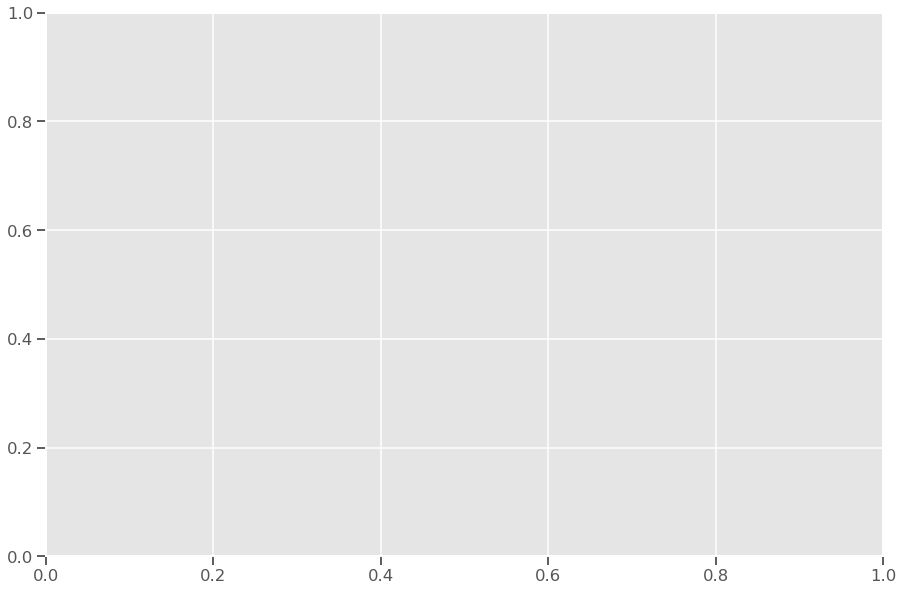

In [67]:
fig, ax = plt.subplots(figsize=(15,10))
ax = sns.boxplot(x='Metadata', hue='Sampling Location', 
                 y='log(p)',
                 data=pagel_long,
                 meanline=True,
                 showmeans=True,
                 meanprops = dict(linestyle='solid', linewidth='2', color='grey')
                )

#Add countes
L = plt.legend()
counts = source_counts[['Isolate', 'Sampling Location']].drop_duplicates().groupby(['Sampling Location']).count()
label_list = []
for txt in ax.get_legend_handles_labels():
    label_list.append(txt)

new_list = []
for txt in label_list[1]:
    new_list.append('{0} ({1})'.format(txt, counts.loc[txt].values[0]))
    
label_list[1] = new_list

ax.legend(handles=label_list[0], labels=label_list[1])
ax.set(xlabel='Gene/MGE Type', ylabel="Count per Genome")
###
#plt.savefig('figures/feature_boxplots.jpg', format='jpg', transparent=False)
plt.show()

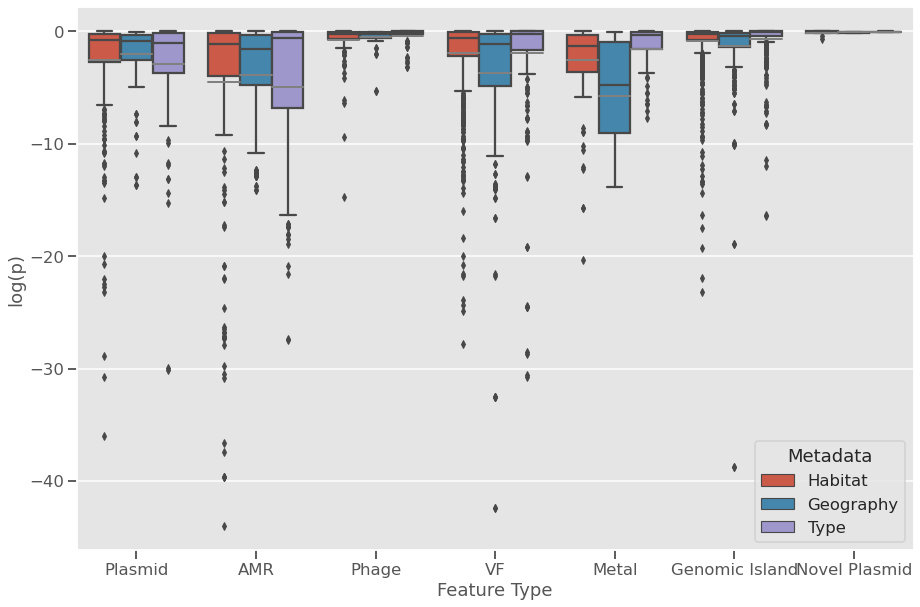

In [68]:
sns.set_context('talk')
fig, ax = plt.subplots(figsize=(15,10))
ax = sns.boxplot(hue='Metadata', x='Feature Type', 
                 y='log(p)',
                 data=pagel_long,
                 meanline=True,
                 showmeans=True,
                 meanprops = dict(linestyle='solid', linewidth='2', color='grey')
                )

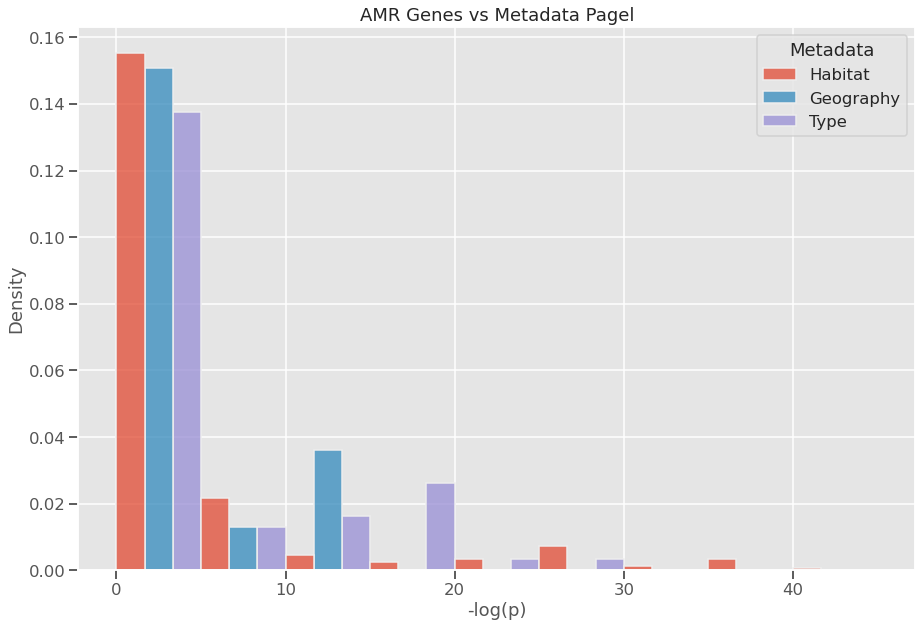

In [69]:
fig, ax = plt.subplots(figsize=(15,10))
ax = sns.histplot(data=pagel_long[pagel_long['Feature Type']=='AMR'], 
                  x='-log(p)',
                  hue='Metadata',
                  multiple='dodge',
                 stat='density', common_norm=False, binwidth=5)
ax.set_title('AMR Genes vs Metadata Pagel')
plt.savefig('p_value_draft.png', bbox_inches="tight")

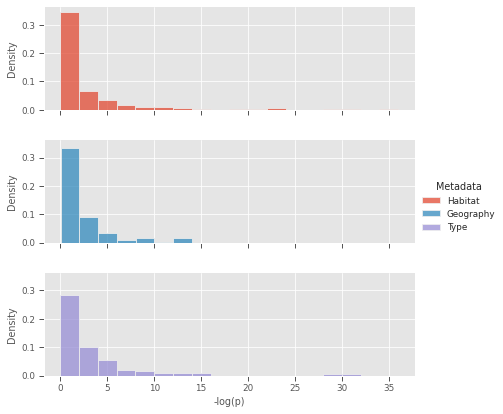

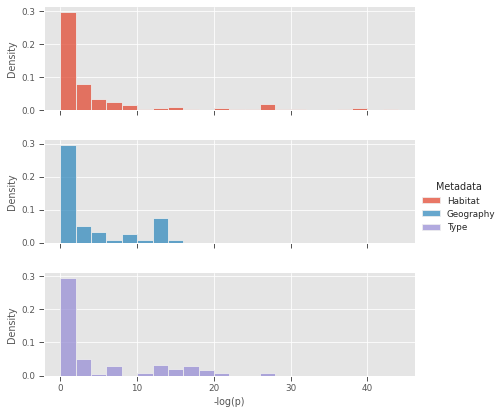

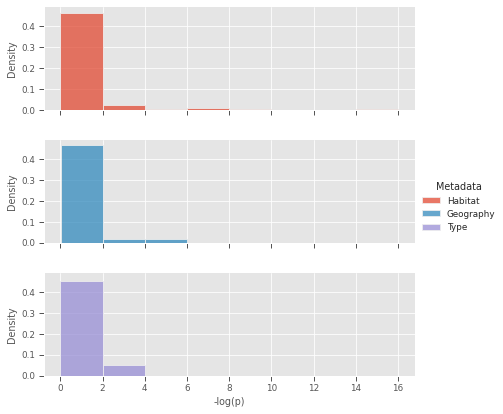

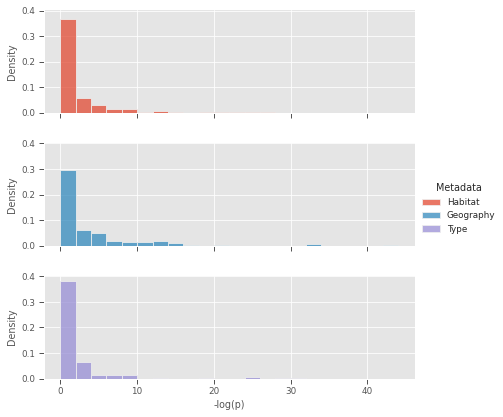

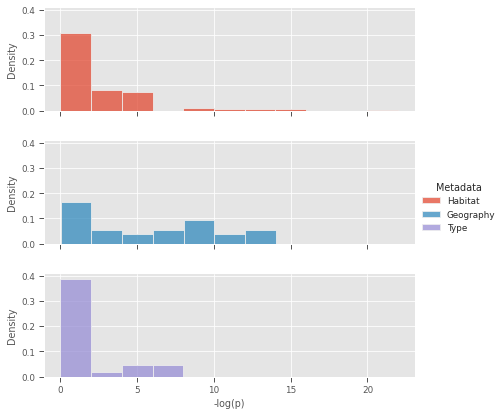

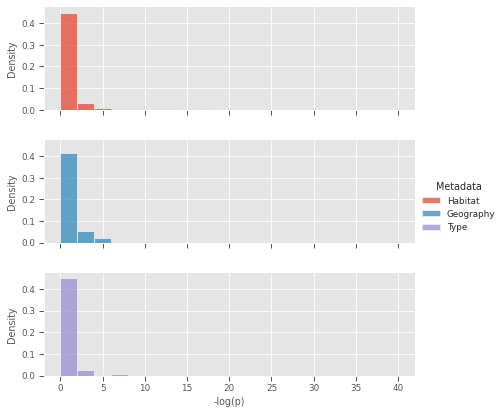

In [73]:
for feat in ['Plasmid', 'AMR', 'Phage', 'VF', 'Metal', 'Genomic Island']:
    sns.set_context('paper')
    g = sns.FacetGrid(data=pagel_long[pagel_long['Feature Type']==feat],
                     row='Metadata', hue='Metadata', sharey=True,
                     height=2, aspect=3)
    g.map(sns.histplot, "-log(p)", binwidth=2, stat="density")
    g.set_titles(row_template='')
    g.add_legend()
    g.fig.subplots_adjust(top=0.95) # adjust the Figure in rp
    #g.fig.suptitle('{} vs metadata p-value distribution'.format(feat))
    plt.savefig('figures/pagel_p_values/{}_pvalues.png'.format(feat), bbox_inches="tight", dpi=300)

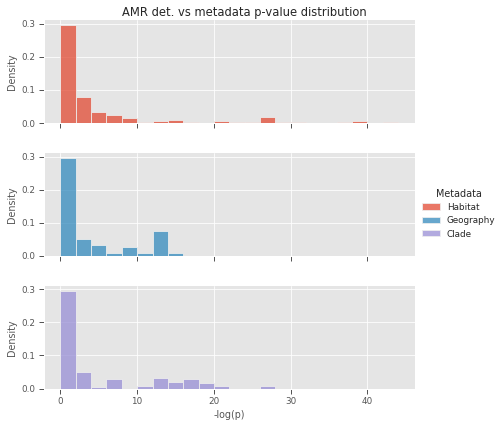

In [72]:
sns.set_context('paper')
g = sns.FacetGrid(data=pagel_long[pagel_long['Feature Type']=='AMR'],
                 row='Metadata', hue='Metadata', sharey=True,
                 height=2, aspect=3)
g.map(sns.histplot, "-log(p)", binwidth=2, stat="density")
g.set_titles(row_template='')
g.add_legend()
g.fig.subplots_adjust(top=0.95) # adjust the Figure in rp
g.fig.suptitle('AMR det. vs metadata p-value distribution')
plt.savefig('p_value_draft2.png', bbox_inches="tight")

In [71]:
g = sns.FacetGrid(tips, col="day", height=3.5, aspect=.65)
g.map(sns.histplot, "total_bill")

NameError: name 'tips' is not defined

Text(0.5, 1.0, 'AMR Genes vs Metadata Pagel')

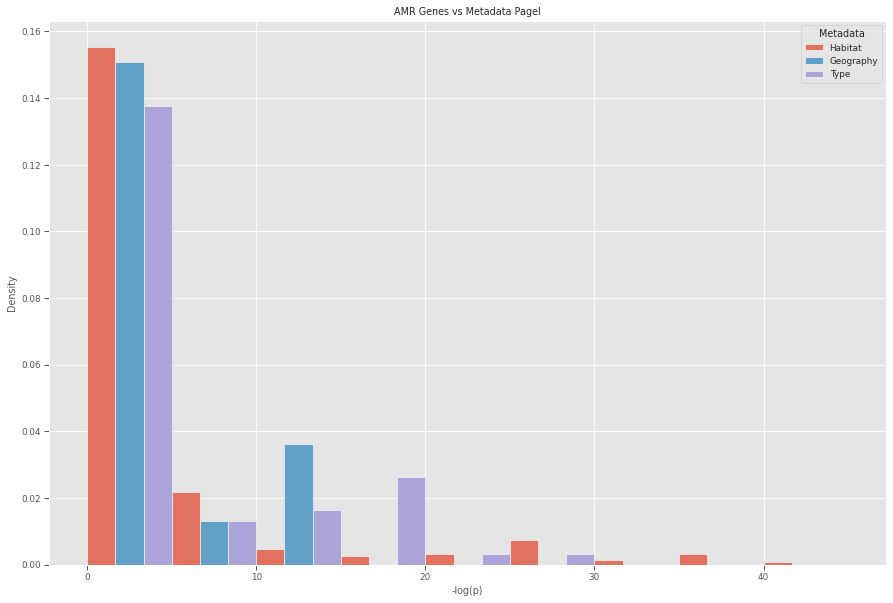

In [72]:
fig, ax = plt.subplots(figsize=(15,10))
ax = sns.histplot(data=pagel_long[pagel_long['Feature Type']=='AMR'], 
                  x='-log(p)',
                  hue='Metadata',
                  multiple='dodge',
                 stat='density', common_norm=False, binwidth=5)
ax.set_title('AMR Genes vs Metadata Pagel')

In [ ]:
fig, ax = plt.subplots(figsize=(15,10))
ax = sns.histplot(data=pagel_long[pagel_long['Feature Type']=='AMR'], 
                  x='-log(p)',
                  hue='Metadata',
                  multiple='dodge',
                 stat='density', common_norm=False, binwidth=5)
ax.set_title('AMR Genes vs Metadata Pagel')

In [66]:
subgraph = pd.read_table('/home/alex/Documents/arete/niche_data/haley_trees/sub_graph_tool/results/copB(BaC3)/copB(BaC3)_neighborhood_PA.csv',sep=',')

In [74]:
set(subgraph.set_index('Genome_ID').index) - set(dm.index)

{nan}

In [78]:
subgraph.dropna().appned()

Genome_ID  copB(BaC3)  hasC(VFC21)  hasC(VFC230)  sagA(VFC30)  \
0      ERR1007500         1.0          1.0           0.0          1.0   
1      ERR1007501         1.0          1.0           0.0          1.0   
2      ERR1036024         1.0          1.0           0.0          1.0   
3     SRR14024953         1.0          1.0           0.0          1.0   
4     SRR14022736         1.0          1.0           0.0          1.0   
...           ...         ...          ...           ...          ...   
1270   ERR1156269         1.0          1.0           0.0          1.0   
1271   ERR1156313         1.0          1.0           0.0          1.0   
1272   ERR1216304         1.0          1.0           0.0          1.0   
1273   ERR1100585         1.0          1.0           0.0          1.0   
1274   ERR1156318         1.0          1.0           0.0          1.0   

      sigA(VFC233)  AC727  ErmB  
0              0.0    0.0   1.0  
1              0.0    0.0   1.0  
2              0.0    1.0   0.0  
3              0.0    0.0   0.0  
4              0.0    0.0   0.0  
...            ...    ...   ...  
1270           0.0    0.0   1.0  
1271           0.0    1.0   1.0  
1272           0.0    0.0   1.0  
1273           0.0    0.0   0.0  
1274           0.0    1.0   1.0  

[1273 rows x 8 columns]

In [72]:
subgraph.set_index('Genome_ID').loc[dm.index]

KeyError: "['Efaecium DO', 'ehirae'] not in index"

In [68]:
dm

ERR1007500  ERR1007501  ERR1036024  ERR1036025  ERR1036026  \
SRR14026489   12.144117   12.144117   12.144105   12.144114   12.144118   
SRR14011024    9.411689    9.411689    8.804472    4.867763    9.411689   
SRR14011027    9.411688    9.411688    8.804471    4.867762    9.411689   
SRR14010960    9.411689    9.411689    8.804472    4.867764    9.411690   
SRR14010994    9.411689    9.411689    8.804472    5.616651    9.411690   
...                 ...         ...         ...         ...         ...   
ERR374689      9.411689    9.411689    8.804472    6.982864    9.411690   
ERR1036034     9.411682    9.411682    8.804466    7.134659    9.411684   
SRR14024961    9.411688    9.411688    8.804471    8.349075    9.411689   
ERR985120      9.411684    9.411684    8.804467    1.059649    9.411685   
ERR1156312     9.411680    9.411680    8.804463    8.349067    9.411681   

             ERR1036028  ERR1036031  ERR1036032  ERR1036033  ERR1036034  ...  \
SRR14026489   12.144117   12.144118   12.144106   12.144118   12.144111  ...   
SRR14011024    5.616654    6.982867    8.652671    8.349080    7.134662  ...   
SRR14011027    5.616653    6.982866    8.652670    8.349079    7.134661  ...   
SRR14010960    5.616654    6.982867    8.652671    8.349080    7.134662  ...   
SRR14010994    2.277023    6.982868    8.652671    8.349080    7.134662  ...   
...                 ...         ...         ...         ...         ...  ...   
ERR374689      6.982867    4.961512    8.652672    8.349080    7.134663  ...   
ERR1036034     7.134662    7.134663    8.652665    8.349074    0.000000  ...   
SRR14024961    8.349078    8.349079    8.652670    6.029889    8.349073  ...   
ERR985120      5.616649    6.982863    8.652667    8.349075    7.134658  ...   
ERR1156312     8.349070    8.349071    8.652662    4.174529    8.349065  ...   

             SRR14026547  SRR14026548  SRR14026549  SRR14026550  SRR14026551  \
SRR14026489    12.295921    12.144124    12.144115    12.144116    12.144119   
SRR14011024    12.295918     9.259895     9.259886     1.872217     5.616656   
SRR14011027    12.295917     9.259894     9.259885     1.248144     5.616655   
SRR14010960    12.295918     9.259895     9.259886     2.246661     5.616656   
SRR14010994    12.295918     9.259895     9.259886     5.616653     2.277025   
...                  ...          ...          ...          ...          ...   
ERR374689      12.295918     9.259895     9.259886     6.982866     6.982869   
ERR1036034     12.295912     9.259889     9.259880     7.134661     7.134664   
SRR14024961    12.295917     9.259894     9.259885     8.349078     8.349080   
ERR985120      12.295913     9.259890     9.259881     4.867761     5.616651   
ERR1156312     12.295909     9.259886     9.259877     8.349070     8.349072   

             SRR14026552  SRR14026553  SRR14026554  SRR14026555     ehirae  
SRR14026489    12.144115    12.144116    12.144116    12.144116  12.599522  
SRR14011024     2.246660     6.982865     0.561665     2.433883  12.599519  
SRR14011027     2.246659     6.982864     1.872216     2.433882  12.599518  
SRR14010960     2.042418     6.982865     2.246661     2.433883  12.599519  
SRR14010994     5.616653     6.982866     5.616654     5.616654  12.599520  
...                  ...          ...          ...          ...        ...  
ERR374689       6.982865     6.064068     6.982866     6.982866  12.599520  
ERR1036034      7.134660     7.134661     7.134661     7.134661  12.599513  
SRR14024961     8.349077     8.349077     8.349078     8.349078  12.599519  
ERR985120       4.867761     6.982861     4.867762     4.867762  12.599515  
ERR1156312      8.349069     8.349069     8.349070     8.349070  12.599511  

[1275 rows x 1275 columns]

In [37]:
G = nx.graphml.read_graphml('../haley_trees/sub_graph_tool/data/pagel_results_as_network_detailed.graphml')

In [38]:
def neighborhood(G, node, n):
    path_lengths = nx.single_source_dijkstra_path_length(G, node)
    return [node for node, length in path_lengths.items()
                    if length <= n]
def filter_graph(G, node, d, lr_threshold, p_threshold):
    edges = []
    for u,v,e in G.edges(data=True):
        if e['lr'] >= lr_threshold and e['p'] <= p_threshold:
            edges.append((u,v))
    H=G.edge_subgraph(edges)
    if node in H.nodes:
        return H.subgraph(neighborhood(H, node, d))
    return G.subgraph([node])

In [39]:
lr = 100
p = 0.0001
d=1
gene = 'vanA'

S = filter_graph(G, gene, d, lr, p)


In [40]:
erm = S.nodes['ermB']
van = S.nodes['vanA']



In [42]:
target_p = {}
target_lr = {}
feature_type = {}
for node in S.nodes:
    if node == gene:
        feature_type
        continue
    edge = S.edges[(node, gene)]
    target_p[node] = edge['p']
    target_lr[node] = edge['lr']

    

In [44]:
nx.set_node_attributes(S, name='target_p', values=target_p)
nx.set_node_attributes(S, name='target_lr', values=target_lr)

In [43]:
target_p

{'vanSA': 0.0,
 'dfrG': 0.0,
 'aad.6.': 0.0,
 'AE577': 0.0,
 'ssaB(VFC39)': 0.0,
 'pilB(VFC35)': 0.0,
 'bopD(VFC15)': 0.0,
 'pilB(VFC44)': 0.0,
 'fss3(VFC42)': 0.0,
 'SAT.4': 0.0,
 'vanXA': 0.0,
 'AC731': 0.0,
 'acm(VFC31)': 0.0,
 'vanYA': 0.0,
 'aac(6′)-Ie-aph(2′′)-Ia': 0.0,
 'vanZA': 0.0,
 'dfrF': 0.0,
 'vanRA': 0.0,
 'vanHA': 0.0,
 'AB369': 0.0,
 "aph(3')-IIIa": 0.0,
 'gi_4': 0.0,
 'slr(VFC10)': 0.0,
 'sgrA(VFC41)': 0.0,
 'AA893': 0.0,
 'bopD(VFC68)': 0.0,
 'ermB': 0.0}

In [244]:
features

feature   source
0           AA083  Plasmid
1           AA840  Plasmid
2           AA890  Plasmid
3           AA891  Plasmid
4           AA892  Plasmid
...           ...      ...
1509   copB(BaC9)    Metal
1510   mco(BaC14)    Metal
1511  copZ(BaC29)    Metal
1512  arsB(BaC30)    Metal
1513  tcrA(BaC16)    Metal

[1514 rows x 2 columns]

In [49]:
data = pd.read_table('../haley_trees/sub_graph_tool/data/all_categories_pa_new.csv', sep=',')

In [57]:
data.dropna()

Isolate  AA083  AA840  AA890  AA891  AA892  AA893  AA894  AA896  \
0      ERR1007500    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
1      ERR1007501    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
2      ERR1036024    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
3     SRR14024953    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
4     SRR14022736    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
...           ...    ...    ...    ...    ...    ...    ...    ...    ...   
1270   ERR1156269    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
1271   ERR1156313    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
1272   ERR1216304    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
1273   ERR1100585    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
1274   ERR1156318    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   

      AA968  ...  copB(BaC28)  tcrB(BaC15)  acr3(BaC31)  ruvB(BaC12)  \
0       0.0  ...          0.0          0.0          0.0          0.0   
1       0.0  ...          0.0          0.0          0.0          0.0   
2       0.0  ...          0.0          0.0          0.0          0.0   
3       0.0  ...          0.0          0.0          0.0          0.0   
4       0.0  ...          0.0          0.0          0.0          0.0   
...     ...  ...          ...          ...          ...          ...   
1270    0.0  ...          0.0          1.0          0.0          0.0   
1271    0.0  ...          0.0          0.0          0.0          0.0   
1272    0.0  ...          0.0          0.0          0.0          0.0   
1273    0.0  ...          0.0          0.0          0.0          0.0   
1274    0.0  ...          0.0          1.0          0.0          0.0   

      chtS(BaC10)  copB(BaC9)  mco(BaC14)  copZ(BaC29)  arsB(BaC30)  \
0             0.0         0.0         0.0          0.0          0.0   
1             0.0         0.0         0.0          0.0          0.0   
2             0.0         0.0         0.0          0.0          0.0   
3             0.0         0.0         0.0          0.0          0.0   
4             0.0         0.0         0.0          0.0          0.0   
...           ...         ...         ...          ...          ...   
1270          0.0         0.0         1.0          0.0          0.0   
1271          0.0         0.0         0.0          0.0          0.0   
1272          0.0         0.0         0.0          0.0          0.0   
1273          0.0         0.0         0.0          0.0          0.0   
1274          0.0         0.0         0.0          0.0          0.0   

      tcrA(BaC16)  
0             0.0  
1             0.0  
2             0.0  
3             0.0  
4             0.0  
...           ...  
1270          1.0  
1271          0.0  
1272          0.0  
1273          0.0  
1274          0.0  

[1273 rows x 1515 columns]

In [241]:
S.nodes['ErmB']

{'water_lr': 107.154442,
 'water_p': 0.0,
 'clinical_lr': 104.14254,
 'clinical_p': 0.0,
 'agriculture_lr': 17.3740820000003,
 'agriculture_p': 0.001634771913046,
 'target_p': 0.0,
 'target_lr': 619.030574}

In [103]:
included = sort_gene_names_by_prefix([node for node in S.nodes])
subset = pa[included]

In [105]:
subset.loc[dm.index]

AA893  AAC.6...Ie.APH.2....Ia  aad.6.  AB369  AC731  acm(VFC31)  \
SRR14026489    0.0                     0.0     0.0    0.0    0.0         0.0   
SRR14011024    0.0                     0.0     0.0    0.0    1.0         1.0   
SRR14011027    1.0                     0.0     0.0    1.0    1.0         1.0   
SRR14010960    0.0                     0.0     1.0    0.0    1.0         1.0   
SRR14010994    0.0                     0.0     1.0    0.0    1.0         1.0   
...            ...                     ...     ...    ...    ...         ...   
ERR374689      0.0                     1.0     1.0    1.0    1.0         1.0   
ERR1036034     0.0                     0.0     0.0    0.0    0.0         1.0   
SRR14024961    0.0                     0.0     0.0    0.0    0.0         1.0   
ERR985120      1.0                     1.0     0.0    1.0    0.0         1.0   
ERR1156312     0.0                     0.0     0.0    0.0    0.0         1.0   

             AE577  APH.3...IIIa  bopD(VFC15)  bopD(VFC68)  ...  sgrA(VFC41)  \
SRR14026489    0.0           0.0          0.0          1.0  ...          0.0   
SRR14011024    1.0           0.0          1.0          0.0  ...          1.0   
SRR14011027    1.0           0.0          1.0          0.0  ...          1.0   
SRR14010960    0.0           1.0          1.0          0.0  ...          1.0   
SRR14010994    1.0           1.0          1.0          0.0  ...          1.0   
...            ...           ...          ...          ...  ...          ...   
ERR374689      1.0           1.0          1.0          0.0  ...          1.0   
ERR1036034     0.0           0.0          1.0          0.0  ...          1.0   
SRR14024961    0.0           0.0          1.0          0.0  ...          0.0   
ERR985120      1.0           0.0          1.0          0.0  ...          1.0   
ERR1156312     0.0           0.0          1.0          0.0  ...          0.0   

             slr(VFC10)  ssaB(VFC39)  vanA  vanHA  vanRA  vanSA  vanXA  vanYA  \
SRR14026489         0.0          0.0   0.0    0.0    0.0    0.0    0.0    0.0   
SRR14011024         1.0          1.0   1.0    1.0    1.0    1.0    1.0    0.0   
SRR14011027         1.0          1.0   1.0    1.0    1.0    1.0    1.0    1.0   
SRR14010960         1.0          1.0   1.0    1.0    1.0    1.0    1.0    1.0   
SRR14010994         1.0          1.0   1.0    1.0    1.0    1.0    1.0    1.0   
...                 ...          ...   ...    ...    ...    ...    ...    ...   
ERR374689           1.0          1.0   1.0    1.0    1.0    1.0    1.0    1.0   
ERR1036034          1.0          0.0   0.0    0.0    0.0    0.0    0.0    0.0   
SRR14024961         1.0          0.0   0.0    0.0    0.0    0.0    0.0    0.0   
ERR985120           1.0          1.0   1.0    1.0    1.0    1.0    1.0    1.0   
ERR1156312          1.0          0.0   0.0    0.0    0.0    0.0    0.0    0.0   

             vanZA  
SRR14026489    0.0  
SRR14011024    0.0  
SRR14011027    1.0  
SRR14010960    1.0  
SRR14010994    1.0  
...            ...  
ERR374689      1.0  
ERR1036034     0.0  
SRR14024961    0.0  
ERR985120      1.0  
ERR1156312     0.0  

[1275 rows x 28 columns]

In [109]:
subset.rename(name_map, axis=1, inplace=True)

/home/alex/anaconda3/envs/nextworkx/lib/python3.9/site-packages/pandas/core/frame.py:5039: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



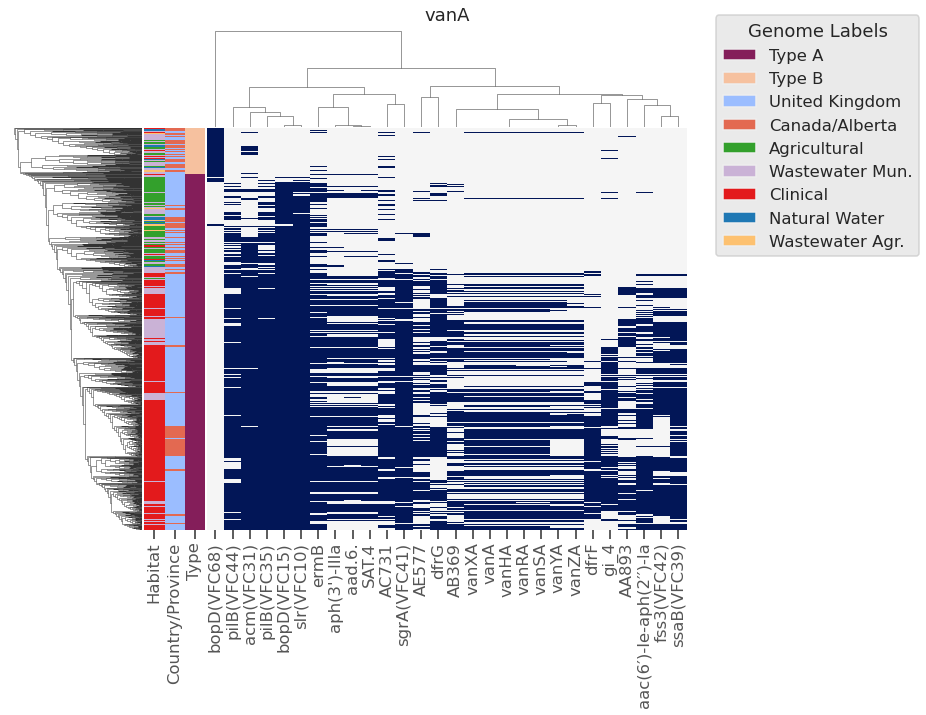

In [110]:
title=gene
handles = [Patch(facecolor=legend_cmap[name]) for name in legend_cmap]
g = sns.clustermap(data=subset.loc[dm.index], 
                   row_linkage=ultrameric_link, 
                   cbar_pos=None, row_colors=genome_colors,
                   cmap=pa_cmap,
                   method='complete', metric='cityblock',
                   xticklabels=1, yticklabels=False)
g.ax_col_dendrogram.set_title(title)
plt.legend(handles, legend_cmap, title='Genome Labels',
           bbox_to_anchor=(1, 1), bbox_transform=plt.gcf().transFigure, loc='upper left')
#plt.xticks(fontsize=6)
plt.savefig('figures/FigureS3{0}__{1}_clustergram.png'.format(panel, feature), bbox_inches='tight', dpi=300)

In [245]:
t = ete3.Tree('core_gene_tree_um.nwk', format=1)

In [60]:
data =pd.read_table('../haley_trees/sub_graph_tool/data/presence_absence_all_relabelled.tsv')


In [62]:
data

Isolate  AA083  AA840  AA890  AA891  AA892  AA893  AA894  AA896  \
0     SRR14026455    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
1     SRR14026462    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
2     SRR14026496    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
3     SRR14026467    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
4     SRR14026460    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
...           ...    ...    ...    ...    ...    ...    ...    ...    ...   
1268   ERR1156273    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
1269   ERR1156274    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
1270   ERR1156276    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
1271   ERR1216304    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
1272   ERR1216305    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   

      AA968  ...  copB(BaC28)  tcrB(BaC15)  acr3(BaC31)  ruvB(BaC12)  \
0       0.0  ...          0.0          0.0          0.0          1.0   
1       0.0  ...          0.0          0.0          0.0          0.0   
2       0.0  ...          0.0          0.0          0.0          0.0   
3       0.0  ...          0.0          0.0          0.0          0.0   
4       0.0  ...          0.0          0.0          0.0          1.0   
...     ...  ...          ...          ...          ...          ...   
1268    0.0  ...          0.0          0.0          0.0          0.0   
1269    0.0  ...          0.0          1.0          0.0          0.0   
1270    0.0  ...          0.0          0.0          0.0          0.0   
1271    0.0  ...          0.0          0.0          0.0          0.0   
1272    0.0  ...          0.0          0.0          0.0          0.0   

      chtS(BaC10)  copB(BaC9)  mco(BaC14)  copZ(BaC29)  arsB(BaC30)  \
0             1.0         1.0         0.0          0.0          0.0   
1             0.0         0.0         0.0          0.0          0.0   
2             0.0         0.0         0.0          0.0          0.0   
3             0.0         0.0         0.0          0.0          0.0   
4             1.0         1.0         0.0          0.0          0.0   
...           ...         ...         ...          ...          ...   
1268          0.0         0.0         0.0          0.0          0.0   
1269          0.0         0.0         1.0          0.0          0.0   
1270          0.0         0.0         0.0          0.0          0.0   
1271          0.0         0.0         0.0          0.0          0.0   
1272          0.0         0.0         0.0          0.0          0.0   

      tcrA(BaC16)  
0             0.0  
1             0.0  
2             0.0  
3             0.0  
4             0.0  
...           ...  
1268          0.0  
1269          1.0  
1270          0.0  
1271          0.0  
1272          0.0  

[1273 rows x 1515 columns]

In [66]:
data.set_index('Isolate')[features[features['source']!="Novel Plasmid"]['feature']]

AA083  AA840  AA890  AA891  AA892  AA893  AA894  AA896  AA968  \
Isolate                                                                      
SRR14026455    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
SRR14026462    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
SRR14026496    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
SRR14026467    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
SRR14026460    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
...            ...    ...    ...    ...    ...    ...    ...    ...    ...   
ERR1156273     0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
ERR1156274     0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
ERR1156276     0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
ERR1216304     0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
ERR1216305     0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   

             AA970  ...  copB(BaC28)  tcrB(BaC15)  acr3(BaC31)  ruvB(BaC12)  \
Isolate             ...                                                       
SRR14026455    0.0  ...          0.0          0.0          0.0          1.0   
SRR14026462    0.0  ...          0.0          0.0          0.0          0.0   
SRR14026496    0.0  ...          0.0          0.0          0.0          0.0   
SRR14026467    0.0  ...          0.0          0.0          0.0          0.0   
SRR14026460    0.0  ...          0.0          0.0          0.0          1.0   
...            ...  ...          ...          ...          ...          ...   
ERR1156273     0.0  ...          0.0          0.0          0.0          0.0   
ERR1156274     0.0  ...          0.0          1.0          0.0          0.0   
ERR1156276     0.0  ...          0.0          0.0          0.0          0.0   
ERR1216304     0.0  ...          0.0          0.0          0.0          0.0   
ERR1216305     0.0  ...          0.0          0.0          0.0          0.0   

             chtS(BaC10)  copB(BaC9)  mco(BaC14)  copZ(BaC29)  arsB(BaC30)  \
Isolate                                                                      
SRR14026455          1.0         1.0         0.0          0.0          0.0   
SRR14026462          0.0         0.0         0.0          0.0          0.0   
SRR14026496          0.0         0.0         0.0          0.0          0.0   
SRR14026467          0.0         0.0         0.0          0.0          0.0   
SRR14026460          1.0         1.0         0.0          0.0          0.0   
...                  ...         ...         ...          ...          ...   
ERR1156273           0.0         0.0         0.0          0.0          0.0   
ERR1156274           0.0         0.0         1.0          0.0          0.0   
ERR1156276           0.0         0.0         0.0          0.0          0.0   
ERR1216304           0.0         0.0         0.0          0.0          0.0   
ERR1216305           0.0         0.0         0.0          0.0          0.0   

             tcrA(BaC16)  
Isolate                   
SRR14026455          0.0  
SRR14026462          0.0  
SRR14026496          0.0  
SRR14026467          0.0  
SRR14026460          0.0  
...                  ...  
ERR1156273           0.0  
ERR1156274           1.0  
ERR1156276           0.0  
ERR1216304           0.0  
ERR1216305           0.0  

[1273 rows x 1339 columns]

In [2]:
amr = pd.read_table('../AMR_Drug_Classes_Curated.tsv')
amr

Feature      Drug Class
0   AAC.6...Ii  aminoglycoside
1         msrC       macrolide
2         ErmB       macrolide
3         ErmT       macrolide
4         ErmA       macrolide
..         ...             ...
77        AcrF       multidrug
78        MexD       multidrug
79        MexB       multidrug
80        MexK       multidrug
81        MexW       multidrug

[82 rows x 2 columns]

In [3]:
amr['Drug Class'].unique()

array(['aminoglycoside', 'macrolide', 'Tetracycline', 'streptothricin',
       'Trimethoprim', 'glycopeptide', 'lincosamide', 'daptomycin',
       'Phenicol', 'phenicol', 'Lincosamide', 'macrolide, lincosamide',
       'oxazolidinones', 'streptogramin', 'quinolone', 'fosfomycin',
       'beta-lactams', 'multidrug'], dtype=object)

In [13]:
amr[amr['Feature']!-]

Feature      Drug Class
0   AAC.6...Ii  aminoglycoside
1         msrC       macrolide
2         ErmB       macrolide
3         ErmT       macrolide
4         ErmA       macrolide
..         ...             ...
77        AcrF       multidrug
78        MexD       multidrug
79        MexB       multidrug
80        MexK       multidrug
81        MexW       multidrug

[82 rows x 2 columns]

In [4]:
pa = pd.read_table('presence_absence_all_relabelled.tsv')
pa

Isolate  AA083  AA840  AA890  AA891  AA892  AA893  AA894  AA896  \
0     SRR14026455    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
1     SRR14026462    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
2     SRR14026496    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
3     SRR14026467    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
4     SRR14026460    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
...           ...    ...    ...    ...    ...    ...    ...    ...    ...   
1268   ERR1156273    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
1269   ERR1156274    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
1270   ERR1156276    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
1271   ERR1216304    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
1272   ERR1216305    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   

      AA968  ...  copB(BaC28)  tcrB(BaC15)  acr3(BaC31)  ruvB(BaC12)  \
0       0.0  ...          0.0          0.0          0.0          1.0   
1       0.0  ...          0.0          0.0          0.0          0.0   
2       0.0  ...          0.0          0.0          0.0          0.0   
3       0.0  ...          0.0          0.0          0.0          0.0   
4       0.0  ...          0.0          0.0          0.0          1.0   
...     ...  ...          ...          ...          ...          ...   
1268    0.0  ...          0.0          0.0          0.0          0.0   
1269    0.0  ...          0.0          1.0          0.0          0.0   
1270    0.0  ...          0.0          0.0          0.0          0.0   
1271    0.0  ...          0.0          0.0          0.0          0.0   
1272    0.0  ...          0.0          0.0          0.0          0.0   

      chtS(BaC10)  copB(BaC9)  mco(BaC14)  copZ(BaC29)  arsB(BaC30)  \
0             1.0         1.0         0.0          0.0          0.0   
1             0.0         0.0         0.0          0.0          0.0   
2             0.0         0.0         0.0          0.0          0.0   
3             0.0         0.0         0.0          0.0          0.0   
4             1.0         1.0         0.0          0.0          0.0   
...           ...         ...         ...          ...          ...   
1268          0.0         0.0         0.0          0.0          0.0   
1269          0.0         0.0         1.0          0.0          0.0   
1270          0.0         0.0         0.0          0.0          0.0   
1271          0.0         0.0         0.0          0.0          0.0   
1272          0.0         0.0         0.0          0.0          0.0   

      tcrA(BaC16)  
0             0.0  
1             0.0  
2             0.0  
3             0.0  
4             0.0  
...           ...  
1268          0.0  
1269          1.0  
1270          0.0  
1271          0.0  
1272          0.0  

[1273 rows x 1515 columns]

In [14]:
amr_pa = pa.set_index('Isolate')[amr[amr['Drug Class']!='multidrug']['Feature']]

In [15]:
amr_pa

AAC.6...Ii  msrC  ErmB  ErmT  ErmA  mphE  mel  LpeA  EreA2  tetM  \
Isolate                                                                         
SRR14026455         1.0   1.0   0.0   0.0   0.0   0.0  0.0   0.0    0.0   1.0   
SRR14026462         1.0   1.0   1.0   0.0   0.0   0.0  0.0   0.0    0.0   1.0   
SRR14026496         1.0   1.0   1.0   0.0   0.0   0.0  0.0   0.0    0.0   1.0   
SRR14026467         1.0   0.0   0.0   0.0   0.0   0.0  0.0   0.0    0.0   1.0   
SRR14026460         1.0   1.0   0.0   0.0   0.0   0.0  0.0   0.0    0.0   0.0   
...                 ...   ...   ...   ...   ...   ...  ...   ...    ...   ...   
ERR1156273          1.0   1.0   0.0   0.0   0.0   0.0  0.0   0.0    0.0   0.0   
ERR1156274          1.0   0.0   1.0   0.0   0.0   0.0  0.0   0.0    0.0   1.0   
ERR1156276          1.0   1.0   0.0   0.0   0.0   0.0  0.0   0.0    0.0   0.0   
ERR1216304          1.0   0.0   1.0   0.0   0.0   0.0  0.0   0.0    0.0   1.0   
ERR1216305          1.0   0.0   1.0   0.0   0.0   0.0  0.0   0.0    0.0   1.0   

             ...  lnuC  emtA  optrA  vatE  QnrVC3  FosB1  OXA.129  NDM.10  \
Isolate      ...                                                            
SRR14026455  ...   0.0   0.0    0.0   0.0     0.0    0.0      0.0     0.0   
SRR14026462  ...   0.0   0.0    0.0   0.0     0.0    0.0      0.0     0.0   
SRR14026496  ...   0.0   0.0    0.0   0.0     0.0    0.0      0.0     0.0   
SRR14026467  ...   0.0   0.0    0.0   0.0     0.0    0.0      0.0     0.0   
SRR14026460  ...   0.0   0.0    0.0   0.0     0.0    0.0      0.0     0.0   
...          ...   ...   ...    ...   ...     ...    ...      ...     ...   
ERR1156273   ...   0.0   0.0    0.0   0.0     0.0    0.0      0.0     0.0   
ERR1156274   ...   0.0   1.0    0.0   0.0     0.0    0.0      0.0     0.0   
ERR1156276   ...   0.0   0.0    0.0   0.0     0.0    0.0      0.0     0.0   
ERR1216304   ...   0.0   0.0    0.0   0.0     0.0    0.0      0.0     0.0   
ERR1216305   ...   0.0   0.0    0.0   0.0     0.0    0.0      0.0     0.0   

             OXA.835  CMY.152  
Isolate                        
SRR14026455      0.0      0.0  
SRR14026462      0.0      0.0  
SRR14026496      0.0      0.0  
SRR14026467      0.0      0.0  
SRR14026460      0.0      0.0  
...              ...      ...  
ERR1156273       0.0      0.0  
ERR1156274       0.0      0.0  
ERR1156276       0.0      0.0  
ERR1216304       0.0      0.0  
ERR1216305       0.0      0.0  

[1273 rows x 71 columns]

In [22]:
presence = amr_pa.melt(var_name='Feature', value_name='Presence')

In [30]:
d = amr_pa.reset_index().melt(id_vars=['Isolate'], var_name='Feature', value_name='Presence').join(amr.set_index('Feature'), on='Feature')
d

Isolate     Feature  Presence      Drug Class
0      SRR14026455  AAC.6...Ii       1.0  aminoglycoside
1      SRR14026462  AAC.6...Ii       1.0  aminoglycoside
2      SRR14026496  AAC.6...Ii       1.0  aminoglycoside
3      SRR14026467  AAC.6...Ii       1.0  aminoglycoside
4      SRR14026460  AAC.6...Ii       1.0  aminoglycoside
...            ...         ...       ...             ...
90378   ERR1156273     CMY.152       0.0    beta-lactams
90379   ERR1156274     CMY.152       0.0    beta-lactams
90380   ERR1156276     CMY.152       0.0    beta-lactams
90381   ERR1216304     CMY.152       0.0    beta-lactams
90382   ERR1216305     CMY.152       0.0    beta-lactams

[90383 rows x 4 columns]

In [32]:
dc_counts = d.groupby(['Drug Class']).sum()
dc_counts

Presence
Drug Class                      
Lincosamide                 33.0
Phenicol                    69.0
Tetracycline              1771.0
Trimethoprim               938.0
aminoglycoside            3192.0
beta-lactams                30.0
daptomycin                 249.0
fosfomycin                   1.0
glycopeptide              3447.0
lincosamide                241.0
macrolide                 2093.0
macrolide, lincosamide       6.0
oxazolidinones              20.0
phenicol                     2.0
quinolone                    2.0
streptogramin                9.0
streptothricin             591.0

In [36]:
d

Isolate     Feature  Presence      Drug Class
0      SRR14026455  AAC.6...Ii       1.0  aminoglycoside
1      SRR14026462  AAC.6...Ii       1.0  aminoglycoside
2      SRR14026496  AAC.6...Ii       1.0  aminoglycoside
3      SRR14026467  AAC.6...Ii       1.0  aminoglycoside
4      SRR14026460  AAC.6...Ii       1.0  aminoglycoside
...            ...         ...       ...             ...
90378   ERR1156273     CMY.152       0.0    beta-lactams
90379   ERR1156274     CMY.152       0.0    beta-lactams
90380   ERR1156276     CMY.152       0.0    beta-lactams
90381   ERR1216304     CMY.152       0.0    beta-lactams
90382   ERR1216305     CMY.152       0.0    beta-lactams

[90383 rows x 4 columns]

<AxesSubplot:xlabel='Drug Class', ylabel='Presence'>

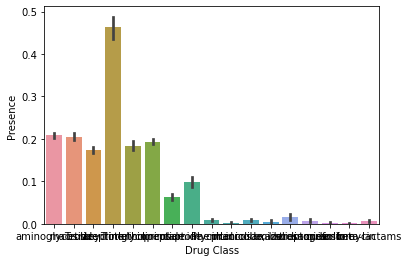

In [38]:
plt.Figure(figsize=(12,12))
sns.barplot(data=d, x='Drug Class', y='Presence')

In [25]:
presence.set_index('Feature').join(amr.set_index('Feature'))


Presence      Drug Class
Feature                              
AAC.6...Iak       0.0  aminoglycoside
AAC.6...Iak       0.0  aminoglycoside
AAC.6...Iak       0.0  aminoglycoside
AAC.6...Iak       0.0  aminoglycoside
AAC.6...Iak       0.0  aminoglycoside
...               ...             ...
vatE              0.0   streptogramin
vatE              0.0   streptogramin
vatE              0.0   streptogramin
vatE              0.0   streptogramin
vatE              0.0   streptogramin

[90383 rows x 2 columns]

In [49]:
s = d.groupby(['Isolate', 'Drug Class']).sum()
s.reset_index()

Isolate      Drug Class  Presence
0       ERR1007500     Lincosamide       0.0
1       ERR1007500        Phenicol       0.0
2       ERR1007500    Tetracycline       2.0
3       ERR1007500    Trimethoprim       1.0
4       ERR1007500  aminoglycoside       2.0
...            ...             ...       ...
21636  SRR14026555  oxazolidinones       0.0
21637  SRR14026555        phenicol       0.0
21638  SRR14026555       quinolone       0.0
21639  SRR14026555   streptogramin       0.0
21640  SRR14026555  streptothricin       1.0

[21641 rows x 3 columns]

In [50]:
def round_down(num):
    if num >= 1:
        return 1
    return 0
s.reset_index(inplace=True)
s['Presence'] = s['Presence'].map(round_down)
s

Isolate      Drug Class  Presence
0       ERR1007500     Lincosamide         0
1       ERR1007500        Phenicol         0
2       ERR1007500    Tetracycline         1
3       ERR1007500    Trimethoprim         1
4       ERR1007500  aminoglycoside         1
...            ...             ...       ...
21636  SRR14026555  oxazolidinones         0
21637  SRR14026555        phenicol         0
21638  SRR14026555       quinolone         0
21639  SRR14026555   streptogramin         0
21640  SRR14026555  streptothricin         1

[21641 rows x 3 columns]

In [57]:
drug_class_pa = s.pivot(index='Isolate', columns='Drug Class', values='Presence')
drug_class_pa.columns.name = ''
drug_class_pa

Lincosamide  Phenicol  Tetracycline  Trimethoprim  \
Isolate                                                          
ERR1007500             0         0             1             1   
ERR1007501             0         0             1             1   
ERR1036024             0         0             1             0   
ERR1036025             0         0             1             0   
ERR1036026             0         0             1             1   
...                  ...       ...           ...           ...   
SRR14026551            0         0             1             1   
SRR14026552            0         0             0             1   
SRR14026553            0         0             1             1   
SRR14026554            0         0             0             1   
SRR14026555            0         0             0             1   

             aminoglycoside  beta-lactams  daptomycin  fosfomycin  \
Isolate                                                             
ERR1007500                1             0           0           0   
ERR1007501                1             0           0           0   
ERR1036024                1             0           0           0   
ERR1036025                1             0           0           0   
ERR1036026                1             0           0           0   
...                     ...           ...         ...         ...   
SRR14026551               1             0           1           0   
SRR14026552               1             0           0           0   
SRR14026553               1             0           0           0   
SRR14026554               1             0           0           0   
SRR14026555               1             0           0           0   

             glycopeptide  lincosamide  macrolide  macrolide, lincosamide  \
Isolate                                                                     
ERR1007500              1            1          1                       0   
ERR1007501              1            1          1                       0   
ERR1036024              0            1          0                       0   
ERR1036025              1            0          1                       0   
ERR1036026              0            0          1                       0   
...                   ...          ...        ...                     ...   
SRR14026551             0            0          1                       0   
SRR14026552             1            0          1                       0   
SRR14026553             0            0          1                       0   
SRR14026554             0            0          1                       0   
SRR14026555             0            0          1                       0   

             oxazolidinones  phenicol  quinolone  streptogramin  \
Isolate                                                           
ERR1007500                0         0          0              0   
ERR1007501                0         0          0              0   
ERR1036024                0         0          0              0   
ERR1036025                0         0          0              0   
ERR1036026                0         0          0              0   
...                     ...       ...        ...            ...   
SRR14026551               0         0          0              0   
SRR14026552               0         0          0              0   
SRR14026553               0         0          0              0   
SRR14026554               0         0          0              0   
SRR14026555               0         0          0              0   

             streptothricin  
Isolate                      
ERR1007500                0  
ERR1007501                0  
ERR1036024                0  
ERR1036025                0  
ERR1036026                1  
...                     ...  
SRR14026551               0  
SRR14026552               0  
SRR14026553               0  
SRR14026554               0  
SRR14026555           

In [66]:
dpa_long = drug_class_pa.reset_index().melt(id_vars=['Isolate'], var_name='Feature')
dc_counts = dpa_long.groupby('Feature').sum()
dc_counts.sort_values(by='value', inplace=True, ascending=False)

In [72]:
fig = go.Figure(go.Bar(x=dc_counts.index, y=dc_counts['value']))
fig.update_yaxes(title={'text': 'Number of Genomes'})
fig.update_layout(title={'text':'Frequency of AMR genes by drug class', 'x':0.5})
fig.show()

In [ ]:
fig = go.Figure()
fig.add_trace(
    go.Bar()
)

In [ ]:
#First genes, then MGEs.
plot_order = ['AMR',  'Metal', 'VF', 'Plasmid', 'Genomic Island',  "Phage"]
titles = []
for i, feat in enumerate(plot_order):
    total = type_counts[type_counts['Feature Type'] == feat].shape[0]
    lt5 = type_counts[(type_counts['Count']<5) & (type_counts['Feature Type']==feat)].shape[0]
    gt5 = total - lt5
    titles.append("{0} ({1}/{2})".format(feat, gt5, total))


fig = make_subplots(rows=3, cols=6, 
                    #subplot_titles=['Gene Counts', 'Genome Lengths (nt)'] + plot_order, 
                    subplot_titles = [None, None] + titles,
                    x_title='Feature Index', 
                    y_title='Feature Count',  
                    vertical_spacing=0.075,
                   specs=[
                       [{'colspan': 3, 'b':0.05}, None, None, {'colspan': 3, 'b':0.05},None, None, ],
                       [{'colspan':2, 't':0.03},None, {'colspan':2,'t':0.03},None, {'colspan':2,'t':0.03}, None],
                       [{'colspan':2, 't':0.03},None, {'colspan':2,'t':0.03},None, {'colspan':2,'t':0.03}, None],
                   ])

#Add the histograms.
fig.add_trace(go.Histogram(x=gsizes['Total length']), row=1, col=1)
fig.add_trace(go.Histogram(x=cdf['Gene Count']), row=1, col=4)

#Add the feature frequency plots.
rows = [2,2,2, 3,3,3]
cols = [1,3,5,1,3,5]
for i, title in enumerate(plot_order):
    row = rows[i]
    col = cols[i]

    data = type_counts[(type_counts['Count']>=5) & (type_counts['Feature Type']==title)]
    x = np.arange(data.shape[0])
    y = data['Count']
    fig.add_trace(go.Bar(x=x, y=y), row=row, col=col)


for i, c in enumerate('ABCDEFGH'):
    label = '({})'.format(c)
    if i == 0:
        xref = "x domain"
        yref = "y domain"
    else:
        xref = "x{} domain".format(i+1)
        yref = "y{} domain".format(i+1)
    fig.add_annotation(xref=xref,
                       yref=yref,
                       x=0.0,
                       y=1.13,
                       text=label,
                       showarrow=False,
                )
        
fig.update_yaxes(title_text='Genome Count', row=1, col=1)
fig.update_layout(height=800, showlegend=False)
fig.update_xaxes(title_text='Gene Count', row=1, col=4)
fig.update_xaxes(title_text='Genome Size (nt)', row=1, col=1)

for annot in fig.layout.annotations:
    if annot['text'] in titles:
        annot['y'] = annot['y'] - 0.05
        annot['font'] = {'size': 14}
    if annot['text'] == 'Feature Count':
        annot['y'] = 0.334
fig.update_layout(font={'size':14})
fig.show()